# CS413 Image and Video Analysis -- Lab 4

## Department of Computer Science, University of Warwick
## July, 2019

## Aims:

The aims of this lab are to

+ Learn about transform domain representations: Discrete Cosine Transforms (DCT) and Fourier Transforms (FT)
+ Calculate and display the basis functions for a DCT and apply them to encode 1D and 2D signals (images)
+ Test the DCT on N x N blocks of an image
+ Learn how the DCT is intvertible
+ Learn how to compress an image using a DCT and measure the entropy and distortion of the image
+ Learn how to calcualte Discrete Fourier Transforms using built-in `numpy.fft` functions
+ Use the Fourier Convolution Theorem to do frequency domain filtering using Gaussian filters
+ Calculate and visualise a block-based DFT 


In [1]:
# import statements

from PIL import Image  # this contain the image class and methods from PIL library
import numpy as np # this imports the numerical and array library 

import matplotlib.pyplot as plt # this is for plotting (showing) images 

## Cosine Waves as basis functions

The DCT is based on projecting signals onto cosine waves at different frequencies. 

It turns out that if we define our waves at integer frequencies in a particular way (1, 2, 3.. etc.) these
turn out to be mutually orthogonal, i.e. their inner-products are zero. 

This means that a signal of the same length (e.g. `N`) can be decomposed into a coordinate in that basis.

The formula for DCT-II wave functions is as follows:
$$
    f(i; w, N) = K \cos \left[ w \frac{\pi}{2 N} (2 i + 1) \right]
$$
where `w` is an integer frequency `0..N-1`, `N` is the length of the wave, and `K` is a normalising
constant
$$
    K = \begin{cases} 
        \sqrt{\frac{1}{N}}, \text{ if } w = 0\\ 
        \sqrt{\frac{2}{N}} \text{ else }
        \end{cases}
$$

First, let's look at what these functions look like.

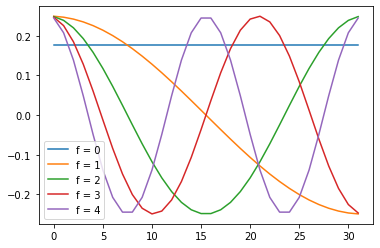

In [2]:
# plot values of 1D DCT wave function for various frequencies

# N samples of a DCT-II wave function at frequency w
def dct_wave(N, w):
    wave = np.zeros(N, dtype='float')
    
    if (w==0):
        norm_factor = np.sqrt(1/N)
    else:
        norm_factor = np.sqrt(2/N)
    for i in range(N):   
        wave[i] = norm_factor * np.cos( w * (np.pi * (2*i + 1))/(2*N) )
        
    return wave

N = 32
for w in range(0,5):
    plt.plot(dct_wave(N, w), label='f = '+str(w))
    
plt.legend()
plt.show()

### Inner products and orthogonality

To encode a signal of size `N` into these functions, we have to take dot products.

In Python, we can use `numpy.dot` to do this, e.g. 

~~~~
    inner_product = np.dot(a, b) # inner or dot product between two 1D arrays
~~~~

But before we use them, we can show that the waves for `w = [1..N]` are mutually orthogonal by
taking dot products one with the other.

If they are orthogonal, then the dot product should be zero.


In [3]:
# demonstrate that any two non-zero frequency waves are orthognal
N = 8

waves = [] # put the N waves into a list
for w in range(1,N):
    waves.append(dct_wave(N, w))
    
inner_products = np.zeros((N-1,N-1))
for u in range(len(waves)):
    for v in range(len(waves)):
        inner_products[u,v] = np.dot(waves[u], waves[v])
    
print(np.round(inner_products,10))
    

[[ 1.  0. -0.  0.  0.  0. -0.]
 [ 0.  1.  0. -0.  0. -0.  0.]
 [-0.  0.  1.  0. -0.  0. -0.]
 [ 0. -0.  0.  1.  0. -0. -0.]
 [ 0.  0. -0.  0.  1.  0.  0.]
 [ 0. -0.  0. -0.  0.  1. -0.]
 [-0.  0. -0. -0.  0. -0.  1.]]


### Using the discrete cosine waves

To use these wave, we take dot products with out signal which is of size `N`.

Becuase there are `N` waves (including the zero frequency one), our signals transformed
from `N` signal samples (in time or space), to `N` frequency coefficients.

## Exercise 1

1. Use a random signal and convert it to `N` DCT coefficients and put them into an array.

Note: you can make a random signal like this:
~~~~
    signal = np.random.uniform(0, 255, size=N)

    plt.plot(signal)
    plt.title('Random signal')
    plt.show()
~~~~

2. Make a plot of the resulting coeffients. How do these compare with the original signal?

[263.18486924  94.71159394 125.15427295 -47.75345405 -24.07923618
 -11.06606761  62.37900933  38.6437736 ]


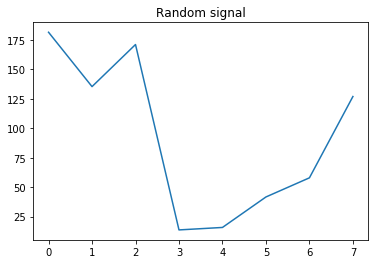

In [4]:
N = 8
signal = np.random.uniform(0, 255, size=N)

waves = [] # put the N waves into a list
for w in range(0,N):
    waves.append(dct_wave(N, w))
    
coeffs = np.dot(waves,signal)
print(coeffs)
plt.plot(signal)
plt.title('Random signal')
plt.show()

## Signal reconstruction: Inverse DCT

Because the DCT coeffients are just coordinates in the functional basis with `N` vectors (the waves),
we can reconstruct the signal by taking a weighted sum of the waves using the coordinates as weights.

Like this
$$
    x = \sum_{w=0}^{N-1}  d(w) f(w, N)
$$
In Python, we need to do a for loop over the `N` waves and multiply them by the coefficients calculated
earlier, e.g.


~~~~
    recon = np.zeros(N)
    for w in range(0,N):
        recon += dct_coeff[w] * dct_wave(N, w)
~~~~

## Exercise 2

1. Implement the reconstruction of the signal given the DCT coeffients of the signal.

2. Plot the reconstruction in the loop as more and more coeffients are used. 

    What do you discover? What do the coeffients of higher frequencies represent in the signal?

3. Repeat the above with a longer signal, say `N = 64`. Does it still work?

4. What happens if in the reconstruction, you choose to ignore coeffients below some percentage of the maximum magnitude (other than the one at zero frequency)?


125.15427294844726


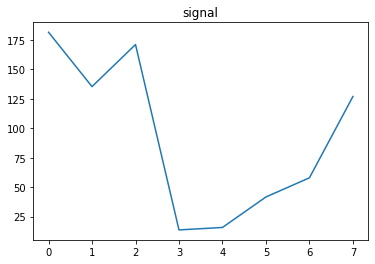

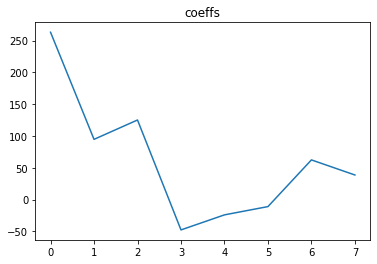

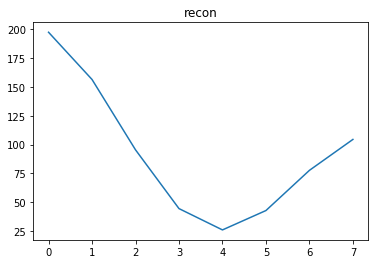

In [5]:
recon = np.zeros(N)

maxco = 0
for w in range(1,N):
    if coeffs[w]>maxco:
        maxco = coeffs[w]
        
print(maxco)
    
for w in range(0,N):
    if coeffs[w] > 0.5*maxco:
        recon += coeffs[w] * dct_wave(N, w)

plt.plot(signal)
plt.title("signal")
plt.show()
    
plt.plot(coeffs)
plt.title("coeffs")
plt.show()

plt.plot(recon)
plt.title("recon")
plt.show()



## 2D Discrete Cosine Transform

To generate and use DCT functions in 2D, it transpires that the 1D functions are separable in
each dimension so we can take products of them to generate 2D basis functions (images).

For any wave with frequency `u` in the x direction, we generate waves at `u` for each row and then
multiply them by waves in the y direction at frequency `v`. This is acheived using the
vector outer-product method:
~~~~
    np.outer(wave_x, wave_y) # wave_x is at frequency u and wave_y is at frequency v
~~~~

The code below generates the basis images for all combinations of `[u, v]` and displays them.

You can see that the waves change in the x and y direction at different rates depending
on `u` and `v`.


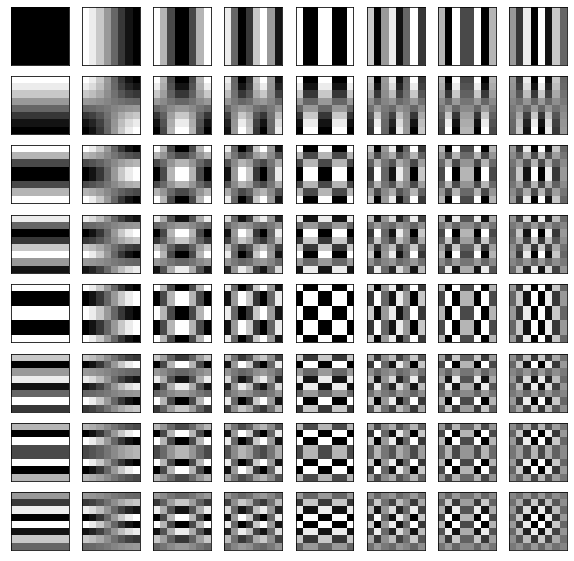

In [6]:
# a 2D dct wave generator
def dct_wave_2d(N, u, v):
    
    wave_x = dct_wave(N, u)
    wave_y = dct_wave(N, v)
    
    return np.outer(wave_x, wave_y)
    

N = 8

fig = plt.figure(figsize=(10,10))
i = 0
for u in range(N):
    for v in range(N):
        
        plt.subplot(N,N,i+1)
        plt.imshow(dct_wave_2d(N, u, v), norm=None, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        i += 1
    
    

## How to use the 2D basis images?

The 2D DCT basis images are used exactly like before, except that this time we 
need to take dot products with input images of the same size.

Also, note that that `numpy.dot()` function needs 1D vectors to do the inner
product so we have to `numpy.flatten()` the input arrays. For example, 
~~~~
    x = image_block
    b = dct_basis_image[u, v]
    
    coefficent = np.dot(x.flatten(), b.flatten()) # dot product x.b
~~~~

## Exercise 3

1. Use `dct_wave_2d` to generate an array of basis images. 

Note you will have to start by making an `N x N x N x N` (4D) array to store these in as 
you'll have to store `N x N`, `N x N` images. Something like this

~~~~
    # create 2D dct basis vectors for 8x8 image block 
    dct_basis = np.zeros((N, N, N, N)) 

    #print(dct_basis.shape)
    for k in range(N):
        for l in range(N):
            dct_basis[k, l] = ...
~~~~

2. Take an `N x N` part of the `zelda.pgm` image and print out your coeffient array.

Try this lovely eye region of the image:
~~~~
    data_dir = ... # location of your data directory

    im = plt.imread(data_dir + 'zelda.pgm')[256:256+64,192:192+64]

    plt.imshow(im, cmap='gray')
    plt.show()
~~~~

3. Using your array of coeffients, confirm that you can reconstruct the input image region.

Note that if your `N` is smaller than 64, e.g. `N = 8` you will have to do each `8 x 8` block of the 
input image separately. OR you could set `N = 64` and do a single block transform.

4. What happens if you only use the 1/4 of the coeffients take from the top-left of the DCT coeffient block?


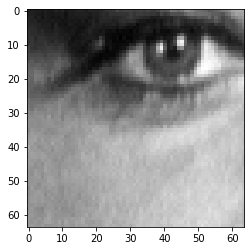

In [7]:
# do a foward transform by taking 8x8 image blocks and calulating the 64 coefficients
# using dot products

data_dir = '/modules/cs413/data/'

im = plt.imread(data_dir + 'zelda.pgm')[256:256+64,192:192+64]

plt.imshow(im, cmap='gray')
plt.show()

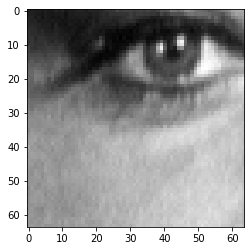

[[ 6.50990625e+03 -9.87859008e+02  3.18161034e+02 ... -2.28784504e-02
  -1.57902885e+00  1.78095011e+00]
 [-2.10981778e+03 -9.19077664e+01  3.61570600e+02 ...  1.56322449e-01
   5.96089184e-01  1.47132421e+00]
 [-6.34964875e+02  1.24709465e+00 -1.32386102e+02 ... -3.23235690e-01
   2.99290607e+00  5.17717788e-01]
 ...
 [ 1.77902030e+00 -2.55799932e+00 -1.18199441e+00 ...  3.26962262e+00
  -1.53481953e-01  8.63768727e-01]
 [ 2.51056625e+00  1.89243369e-01  1.08990831e+00 ... -1.18637889e+00
  -7.08076425e-01 -1.18756683e+00]
 [-1.55709474e+00 -2.15327487e-01  3.93790970e-01 ...  1.89277930e+00
   2.96911394e+00  1.03914884e+00]]


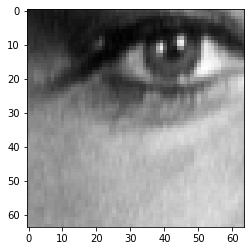

In [8]:
N=64
# create 2D dct basis vectors for 8x8 image block 
dct_basis = np.zeros((N, N, N, N)) 

#print(dct_basis.shape)
for k in range(N):
    for l in range(N):
        dct_basis[k, l] = dct_wave_2d(N,k,l)
    
data_dir = '/modules/cs413/data/'

im = plt.imread(data_dir + 'zelda.pgm')[256:256+64,192:192+64]

plt.imshow(im, cmap='gray')
plt.show()

coeffs = np.zeros((N,N))
for k in range(N):
    for l in range(N):
        coefficient = np.dot(im.flatten(), dct_basis[k,l].flatten()) # dot product x.b
        #print(coefficient)
        coeffs[k,l] = coefficient
print(coeffs)


def DCT_inv(coeffs, dct_basis, N, c):
    recon = np.zeros((N,N))
    for k in range(N):
        for l in range(N):
            if k<=N//c or l<=N//c:
                recon+=coeffs[k,l]*dct_basis[k,l]
    return recon

recond = DCT_inv(coeffs, dct_basis,N, 2)           
plt.imshow(recond, cmap='gray')
plt.show()

## Fourier Transforms and Filtering

The Fourier Transform (FT) does both a Cosine and a Sine decomposition of an input signal and encodes these 
as the real and imanginary parts of a complex number. 

For a 1D discrete signal with `N` values, the FT produces `N` frequency coefficients representing the amounts
of cosine and sine waves at frequences `-N/2..N/2` in the signal.

For the following exploration of Fourier Transforms we will use the `numpy.fft` functions:
    
    1. `fft2` which does a 2D discrete Fourier Transform (DFT) of an array. Note that this produce a complex-valued
    set of frequency coeffients.
    
    2. `ifft2' which does an inverse 2D DFT. Note this takes a complex-valued array
    
    3. `fftshift` which centres the output of `fft2` so that the zero-frequency is in the centre. 
    This is useful for display.
    

### Fourier Transform Experiements

We will begin by running a 2D DFT on part of the FM test pattern image we used in the first lab.



(64, 64)


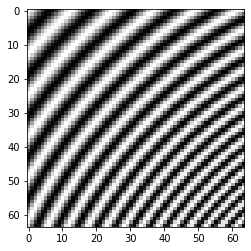

In [9]:
fm = plt.imread(data_dir + 'testimage512.gif')[:,:,0]

fm_part = fm[128:128+64,128:128+64]

print(fm_part.shape)
plt.imshow(fm_part, cmap='gray')
plt.show()


DFT coefficient image has size  (64, 64)  and type  complex128


[]

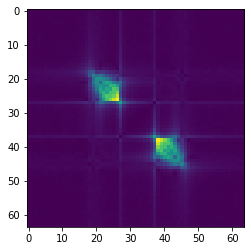

In [10]:
# subtract the mean value so the zero frequency does not
# dominate the spectrum display

# calculate the 2D DFT
dft = np.fft.fft2(fm_part - np.mean(fm_part)) # zero mean

print('DFT coefficient image has size ', dft.shape, ' and type ', dft.dtype)

# centre the transform so that zero frequency is in the centre
dft_centred = np.fft.fftshift(dft)

# display the absolute value of the spectrum (the magnitude spectrum)
plt.imshow(np.abs(dft_centred))
plt.plot()

## Filtering using the DFT 

We can filter an image by attenuating low frequencies or high frequencies or both.

A simple way to stop high-frequencies (low-pass filtering) is to weight down high frequencies which
are located away from the centre of the transform.

The steps of image filtering using the DFT are:
    
    1. Calculate the DFT of the image
    2. Multiply by the filter weights (e.g. Gaussian filter)
    3. Inverse DFT
    
Note that this does not require a spatial convolution operation but only a element-wise multiply in
the Fourier Domain. This is because of the Fourier Convolution Theorem.

Look at the `dft_filter` funciton below and notice the implementation of the three steps. Here
the `kernel` is assumed to be a set of filter weights -- usually centred on the origin -- which
are the same size as the image.

In [11]:
# filtering

# assume that the kernel is centred
def dft_filter(im, kernel):
    
    # do foward dft of im and centre coefficients
    dft = np.fft.fftshift(np.fft.fft2(im))
    
    dft_filtered = np.multiply(kernel, dft) # element wise multiplication
    
    # do inverse dft
    im_filtered = np.fft.ifft2(np.fft.fftshift(dft_filtered)) 
    
    return im_filtered.real

def gaussian_kernel(sigma, norm=True):
    
    size = int(np.ceil(6 * sigma))  # kernel width is 6 x sigma
    
    if (size%2==0): # is the size even?
        size = size + 1 # make it odd 
        
    kernel = np.zeros((size,size), dtype='float') # kernel array
    
    h = size//2 # half size
    for y in range(0,size):
        for x in range(0,size):
            x2 = (x-h)*(x-h)
            y2 = (y-h)*(y-h)
            kernel[y, x] = np.exp(-(x2+y2)/(2*sigma*sigma))
    
    if norm:
        kernel /= np.sum(kernel) # normalise the kernel
    
    return kernel

### Padding the filter kernel

The task of applying the filter is to design a filter function, e.g. using
a Gaussian Kernel but it has to be centred and padded-out to be the same
size as the image to be filtered.


(45, 45)


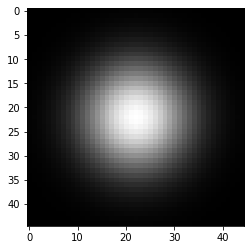

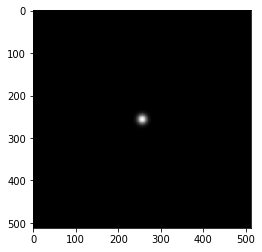

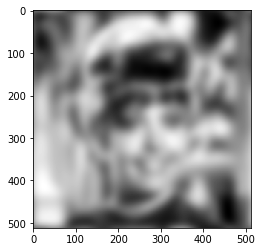

In [12]:


zelda = plt.imread(data_dir + 'zelda.pgm')


# pad out kernel to be same size as the image
gauss = gaussian_kernel(7.5, norm=False)
print(gauss.shape)

# becuase the filter kernel is odd-sized the padding is 1 more on the left/above than right/below
pad_width = (zelda.shape[0]-gauss.shape[0])//2
lp_filter = np.pad(gauss, ((pad_width+1,pad_width),(pad_width+1,pad_width)), mode='constant')

# display the original kernel
plt.imshow(gauss, cmap='gray')
plt.show()

# display the filter
plt.imshow(lp_filter, cmap='gray')
plt.show()

# apply the filter 
lp_filtered = dft_filter(zelda, lp_filter)

# display the result
plt.imshow(lp_filtered, cmap='gray')
plt.show()

## Exercise 4

1. Repeat the fitlering above by change the filter kernel standard deviation. What do you find?

2. Try making a Difference of Gaussians filter and then apply this in the using `dft_filter`. What is the result and
why?

3. Make a high-pass filer from the original low-pass filter (single Gaussian). You need to make the filter 
go to zero at the centre and go to 1 at the boundaries.

Hint: To pad the filter so that the border values are 1 we need to write:
~~~~
    hp_filter = np.pad(hp_kernel, ((pad_width+1,pad_width),(pad_width+1,pad_width)), 
                   mode='constant', constant_values=(1.0)
~~~~

(91, 91)


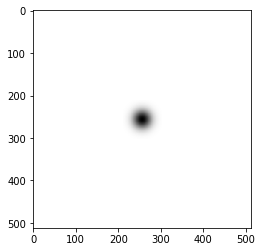

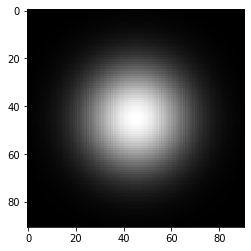

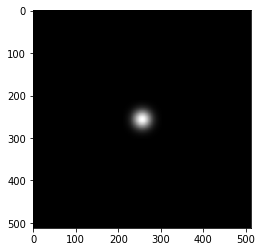

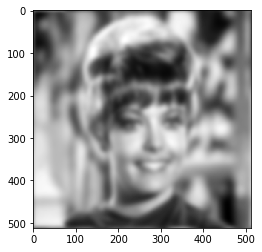

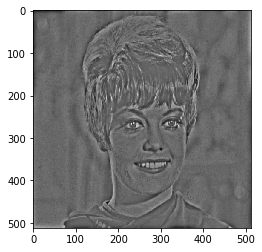

In [21]:
zelda = plt.imread(data_dir + 'zelda.pgm')


# pad out kernel to be same size as the image
gauss = gaussian_kernel(15, norm=False)
print(gauss.shape)

# becuase the filter kernel is odd-sized the padding is 1 more on the left/above than right/below
pad_width = (zelda.shape[0]-gauss.shape[0])//2
lp_filter = np.pad(gauss, ((pad_width+1,pad_width),(pad_width+1,pad_width)), mode='constant')
hp_filter = np.zeros(lp_filter.shape)

for v in range(lp_filter.shape[0]):
    for w in range(lp_filter.shape[1]):
        hp_filter[v][w] = 1-lp_filter[v][w]

plt.imshow(hp_filter, cmap='gray')
plt.show()

# display the original kernel
plt.imshow(gauss, cmap='gray')
plt.show()

# display the filter
plt.imshow(lp_filter, cmap='gray')
plt.show()

# apply the filter 
lp_filtered = dft_filter(zelda, lp_filter)
hp_filtered = dft_filter(zelda, hp_filter)

# display the result
plt.imshow(lp_filtered, cmap='gray')
plt.show()

plt.imshow(hp_filtered, cmap='gray')
plt.show()

# Magnitude and Phase

The DFT produces complex coefficients because it is both a cosine and a sine transform in one.

Each frequency is represented as a magnitude and a phase (angle) and tells us not only how much
of that spatial frequency is present in the image but also its phase (relative offset of the wave).

We can visualise the magnitude and the phase separately, although the phase is hard to interpret
as it wraps around. But what exactly does the phase represent.

One interesting experiment is to take two different images, say A and B, and swap their phases, like this:

1. Calculate DFT(A) and DFT(B) and write them as the pairs 
    DFT(A) = {abs(A), angle(A)}, DFT(B) = {abs(B), angle(B)}.

2. Swap the phases so that we have DFT(A') = {abs(A), angle(B)}, and DFT(B') = {abs(B), angle(A)}

3. Inverse DFT A' and B' and visualise the results.



In [25]:
A = plt.imread(data_dir + 'zelda.pgm')
B = plt.imread(data_dir + 'zebra.gif')[:,:,0] # take one channel

print(A.shape)
print(B.shape)

"""
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(A, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('zelda')
plt.subplot(1,2,2)
plt.imshow(B, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('zebras')
plt.show()"""

(512, 512)
(512, 512)


"\nfig = plt.figure(figsize=(20,10))\nplt.subplot(1,2,1)\nplt.imshow(A, cmap='gray')\nplt.xticks([])\nplt.yticks([])\nplt.title('zelda')\nplt.subplot(1,2,2)\nplt.imshow(B, cmap='gray')\nplt.xticks([])\nplt.yticks([])\nplt.title('zebras')\nplt.show()"

In [24]:
# now dft and swap phases
dft_A = np.fft.fft2(A)
mag_A = np.abs(dft_A)
angle_A = np.angle(dft_A)

dft_B = np.fft.fft2(B)
mag_B = np.abs(dft_B)
angle_B = np.angle(dft_B)

# swap phases
dft_A2 = mag_A * np.exp(1j*angle_B)
dft_B2 = mag_B * np.exp(1j*angle_A)

# inverse dft
A2 = np.fft.ifft2(dft_A2).real
B2 = np.fft.ifft2(dft_B2).real

"""fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(A2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('zelda with phase of zebras')
plt.subplot(1,2,2)
plt.imshow(B2,  cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('zebras with phase of zelda')
plt.show()"""

"fig = plt.figure(figsize=(20,10))\nplt.subplot(1,2,1)\nplt.imshow(A2, cmap='gray')\nplt.xticks([])\nplt.yticks([])\nplt.title('zelda with phase of zebras')\nplt.subplot(1,2,2)\nplt.imshow(B2,  cmap='gray')\nplt.xticks([])\nplt.yticks([])\nplt.title('zebras with phase of zelda')\nplt.show()"

# Block-based DFT (Short-Time Fourier Transform -- STFT)

The DFT has the problem that it can tell us about the frequencies in the whole image with good
precision but not where the are localised. 

We can perform what is known as a Short-Time Fourier Transform (STFT) or windowed FT to localise 
the frequency content to a block in the image. This is exactly like how the DCT works.



In [82]:
# load our favourite image
im = plt.imread(data_dir + 'zelda.pgm')

# tile image into blocks of a given size
block_size = 64

# the output image array
dft = np.zeros((im.shape[0], im.shape[1]))
mean = np.mean(im)

for i in range(0,im.shape[0],block_size):
    for j in range(0,im.shape[0],block_size):
        
        block = im[i:i+block_size,j:j+block_size] - mean
        dft_block = np.fft.fft2(block)
        
        #dft_block[0,0] = 0

        dft_block_centred = np.fft.fftshift(dft_block)
        
        dft[i:i+block_size,j:j+block_size] = dft_block_centred
    
#fig = plt.figure(figsize=(20,20))
#plt.imshow(np.log(1 + np.abs(dft))) # log the the spectrum to visualise it better
#plt.plot()

/local/java/python-pip-packages.cs413/lib64/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


(61, 61)


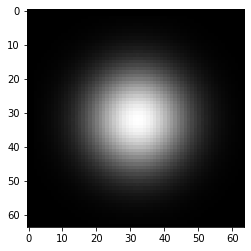

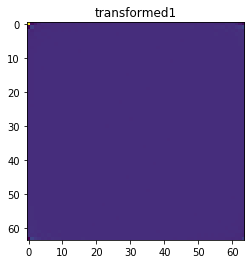

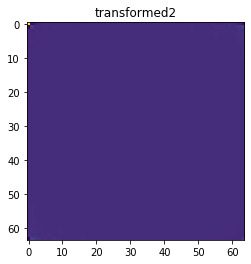

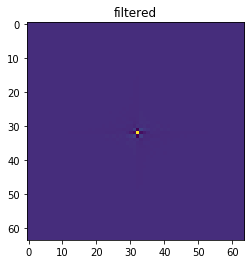

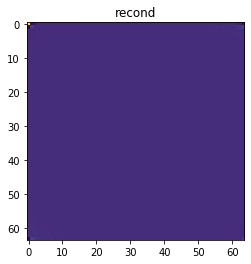

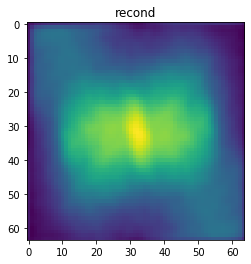

/local/java/python-pip-packages.cs413/lib64/python3.6/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


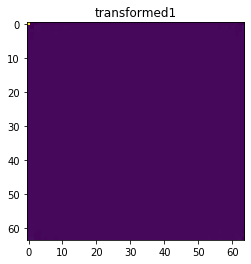

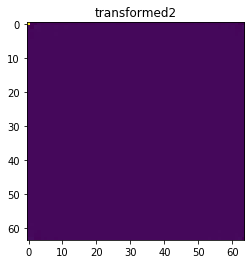

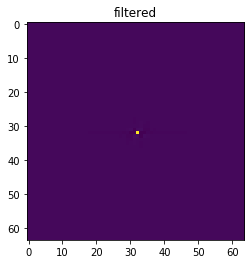

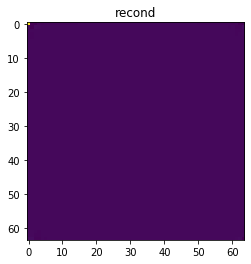

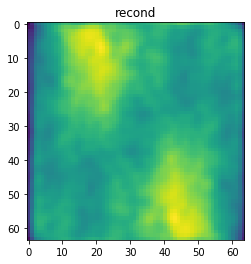

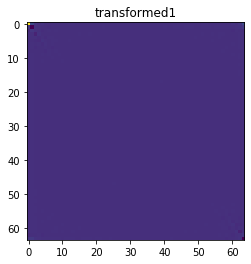

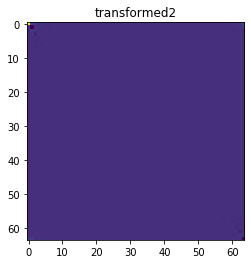

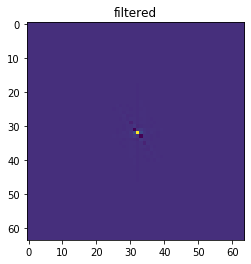

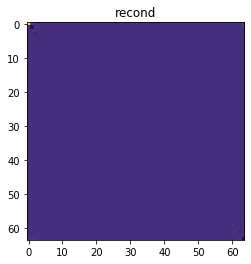

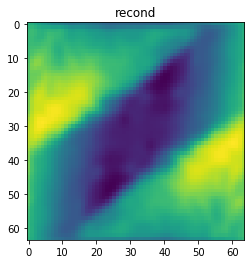

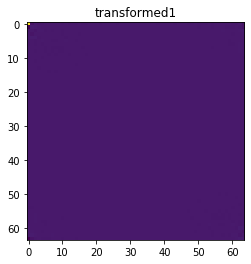

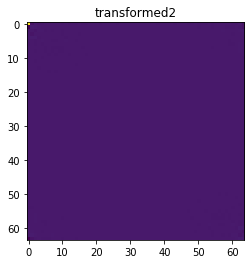

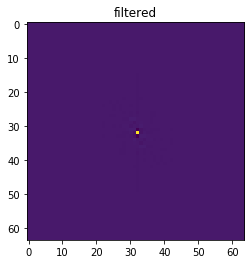

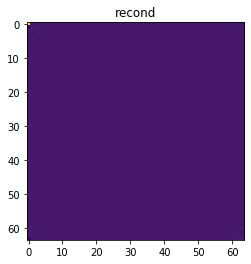

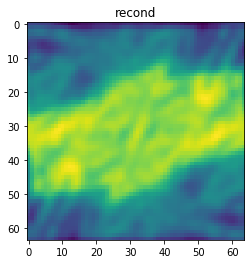

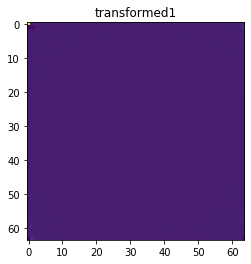

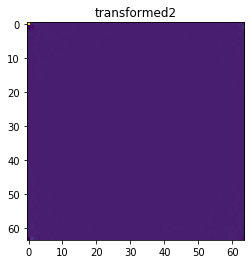

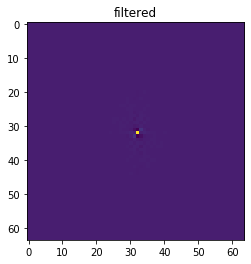

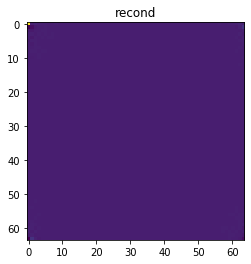

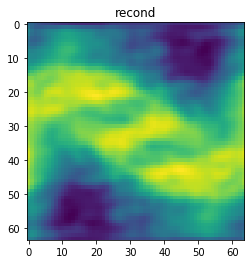

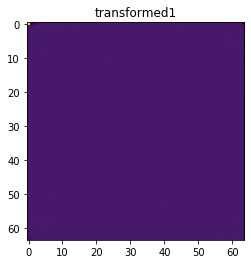

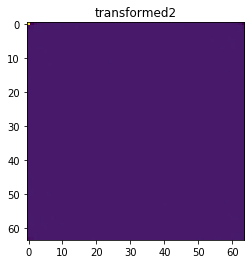

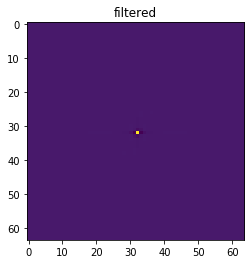

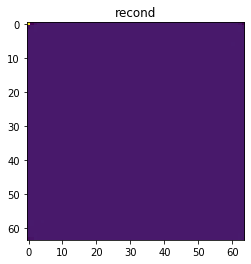

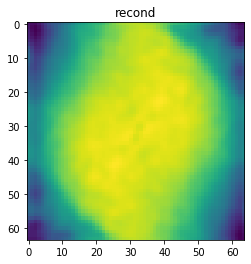

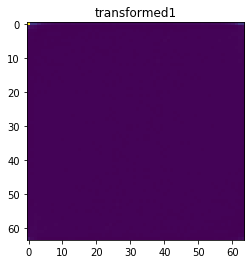

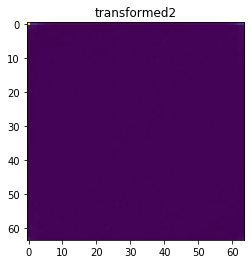

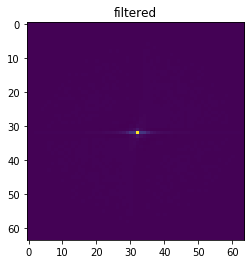

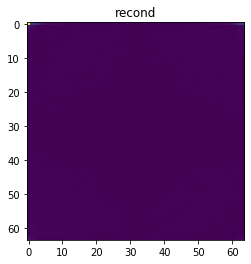

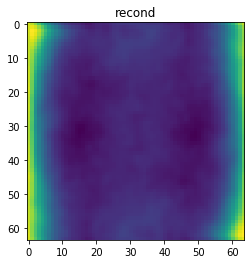

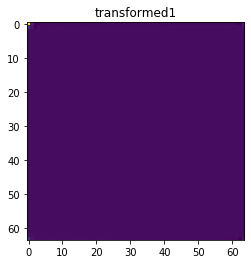

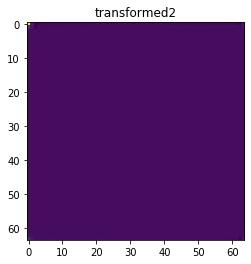

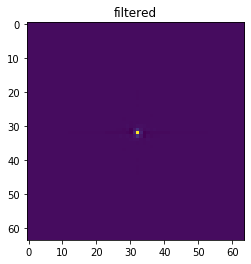

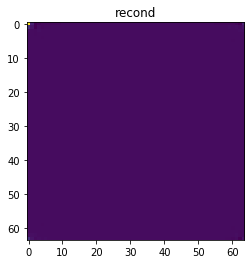

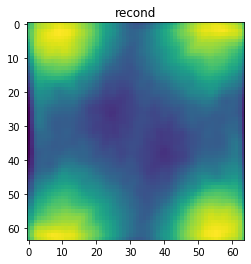

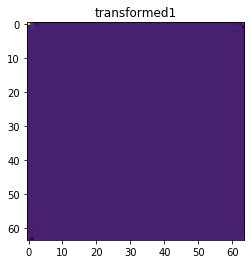

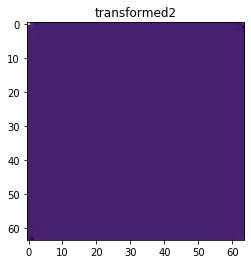

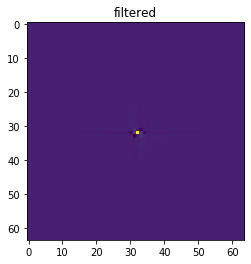

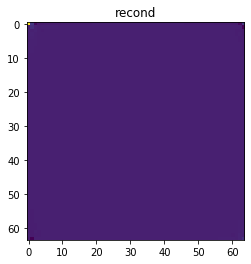

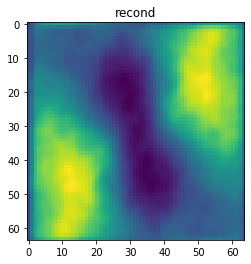

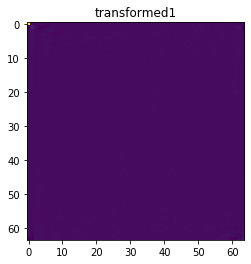

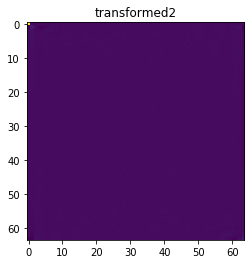

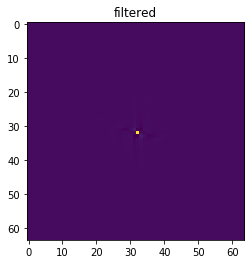

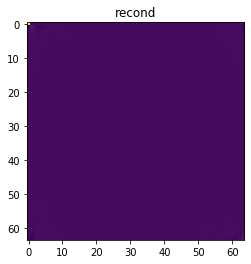

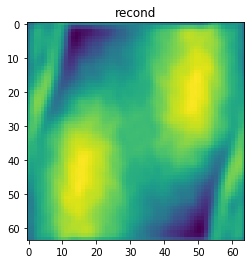

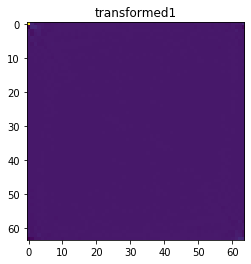

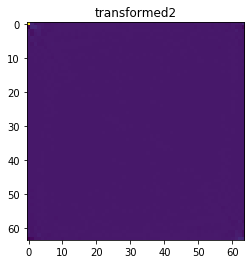

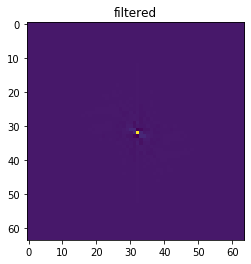

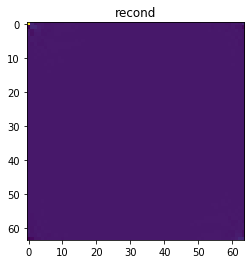

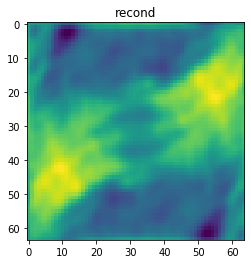

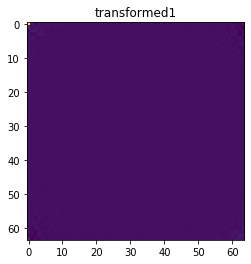

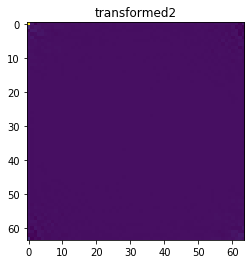

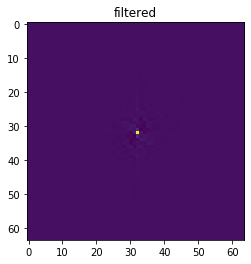

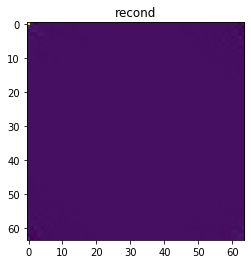

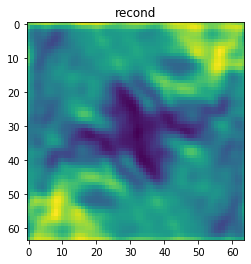

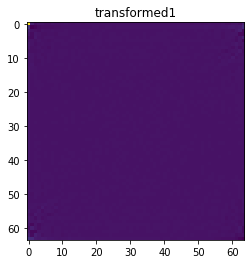

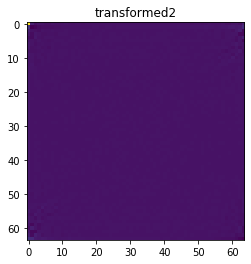

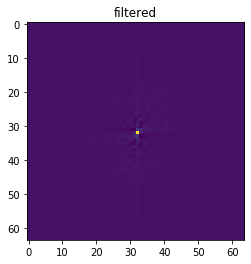

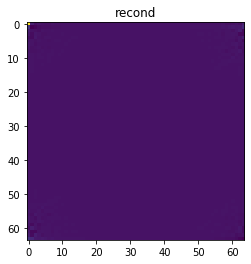

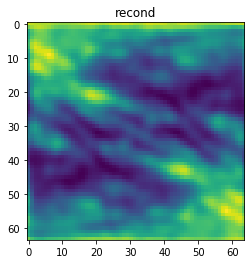

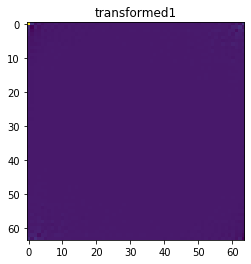

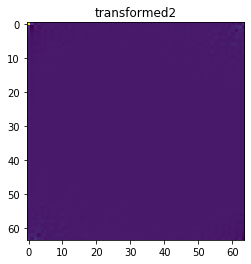

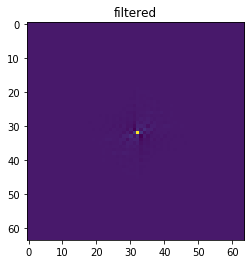

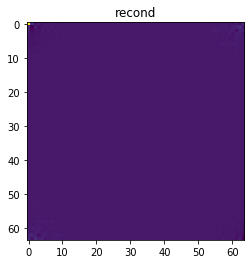

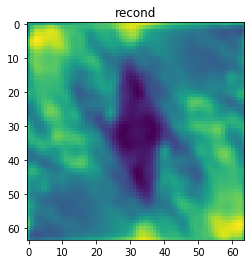

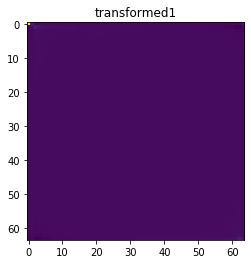

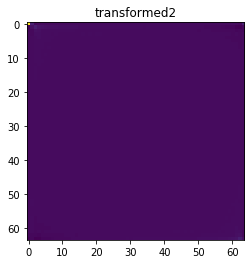

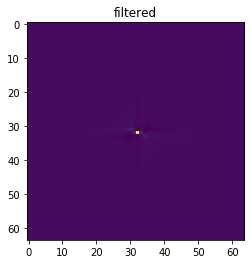

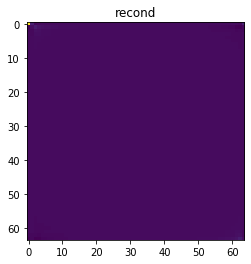

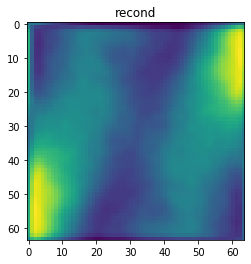

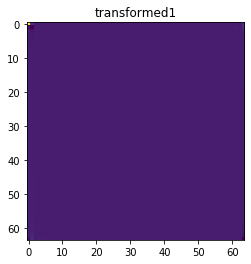

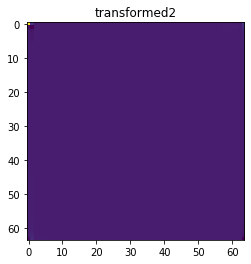

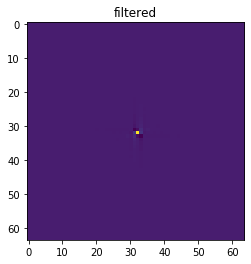

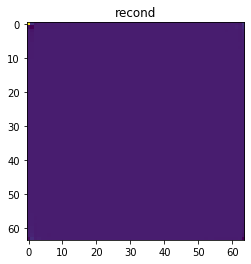

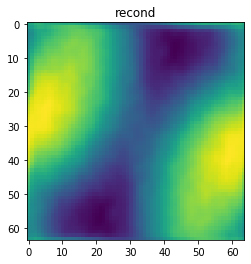

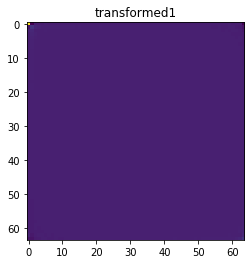

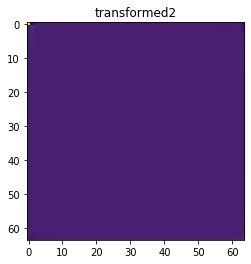

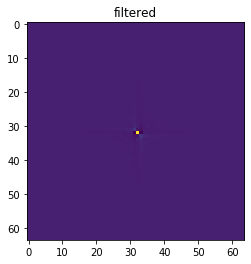

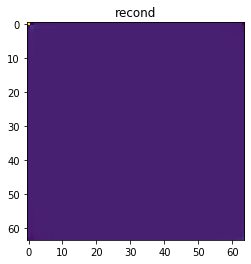

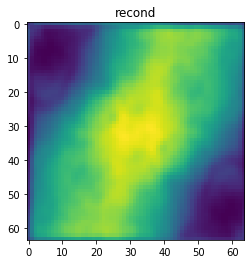

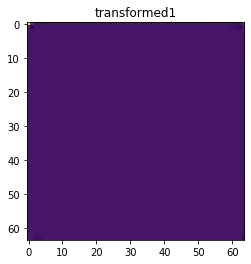

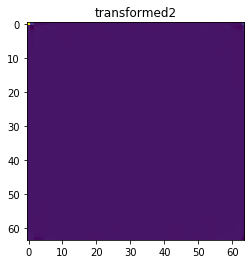

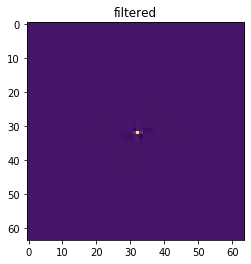

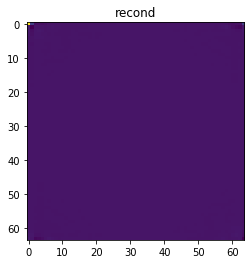

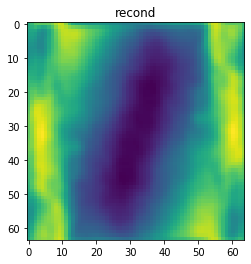

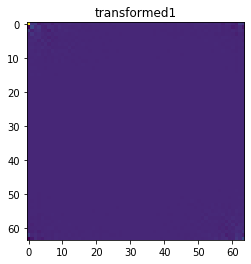

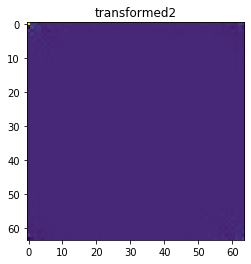

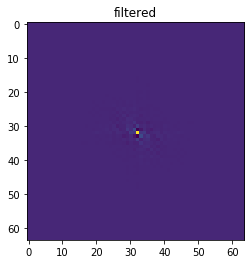

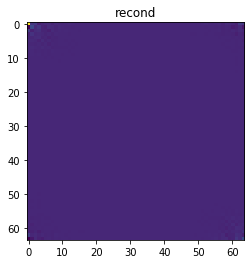

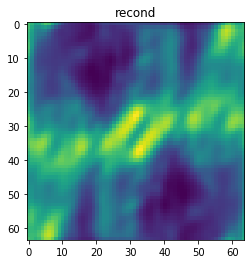

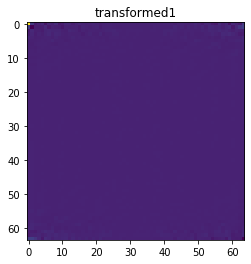

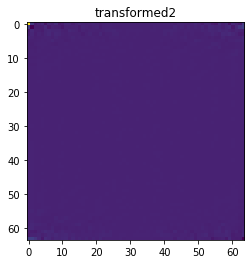

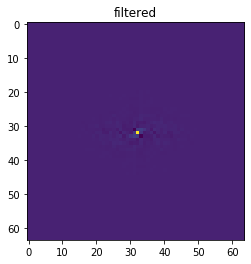

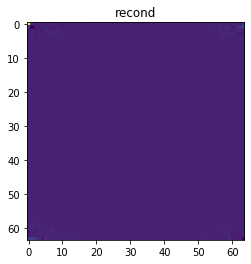

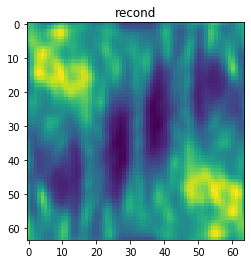

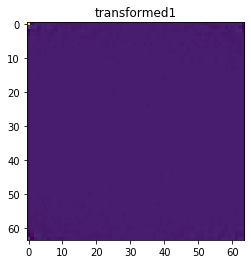

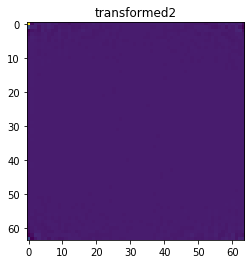

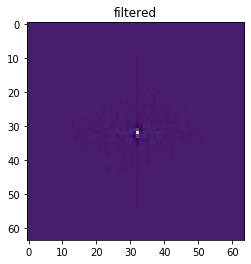

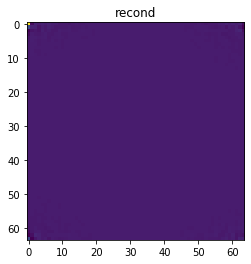

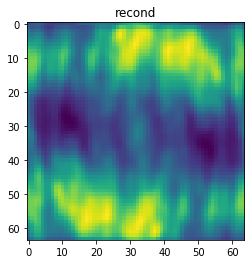

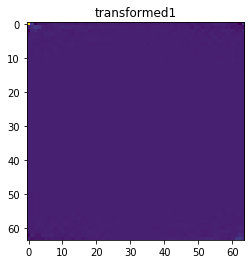

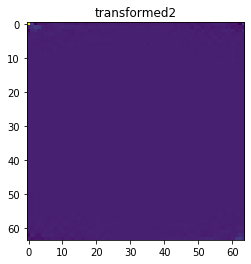

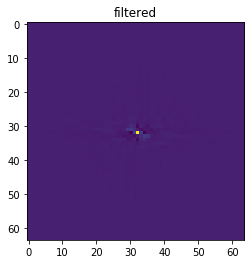

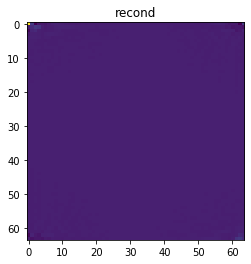

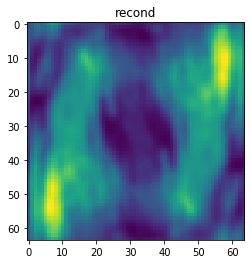

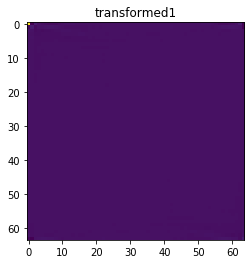

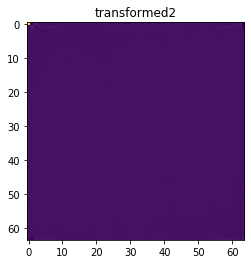

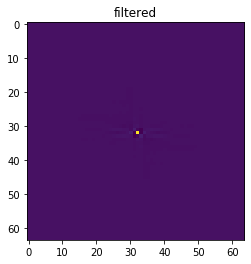

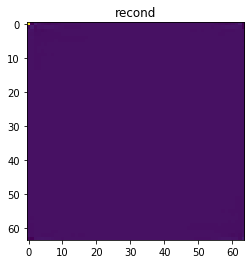

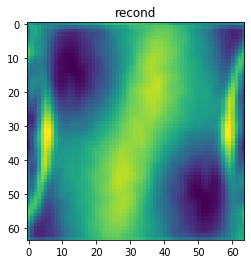

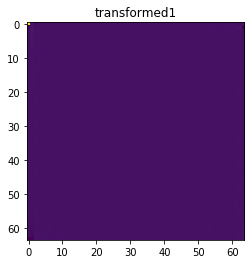

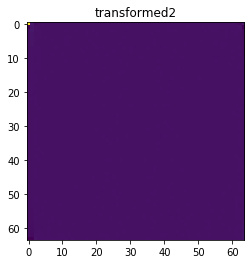

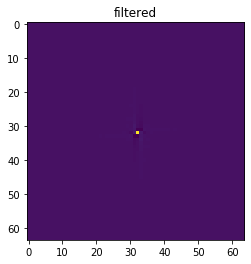

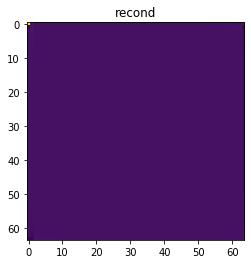

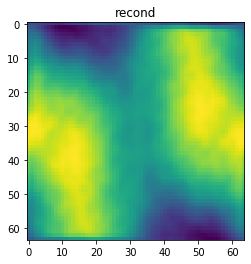

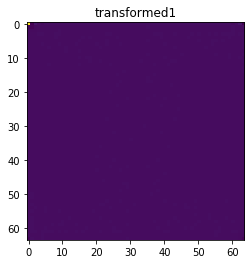

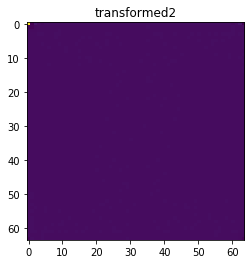

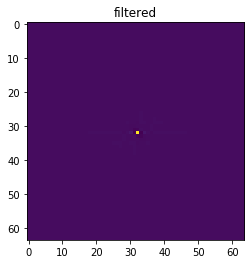

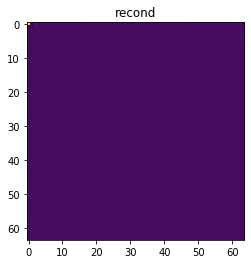

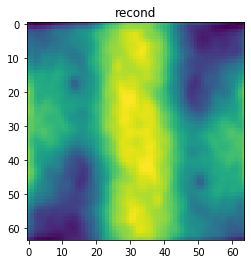

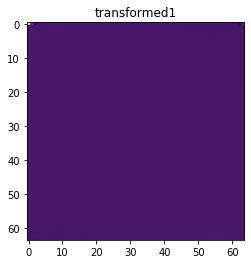

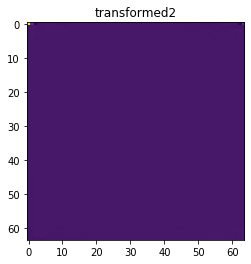

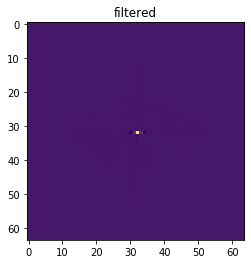

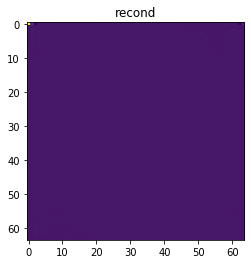

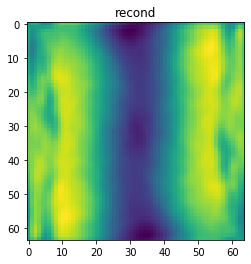

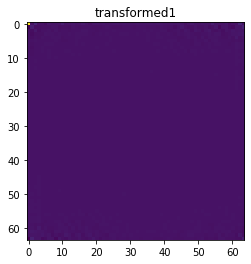

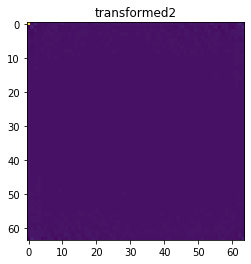

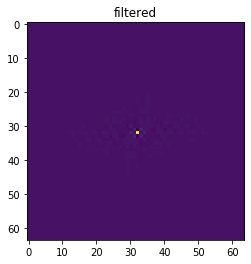

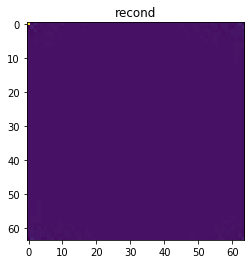

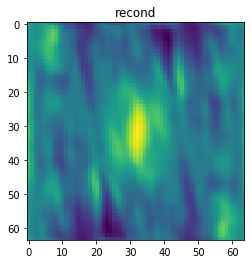

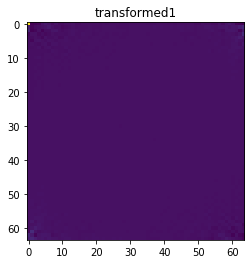

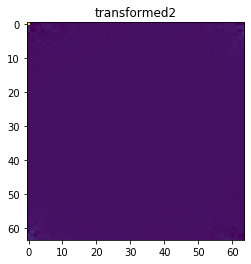

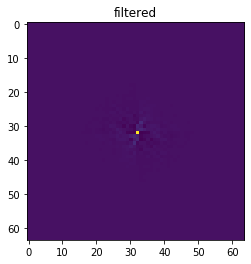

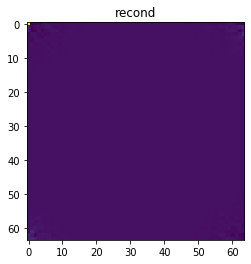

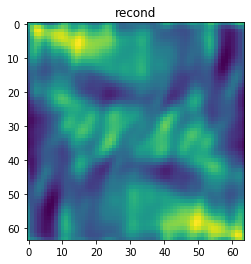

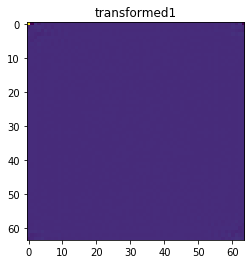

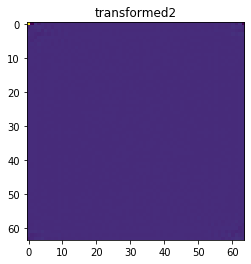

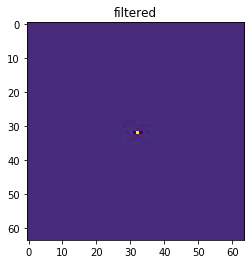

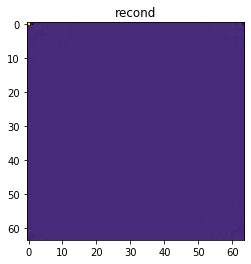

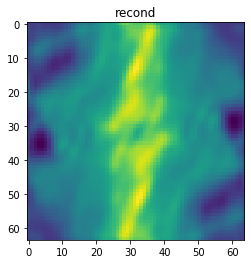

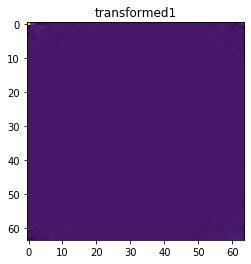

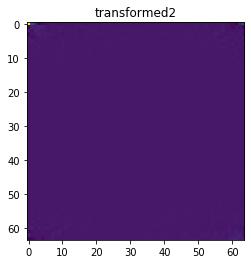

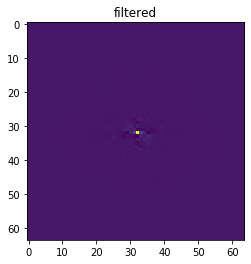

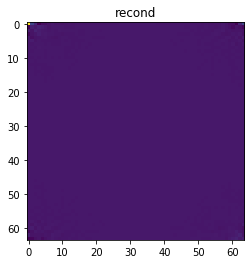

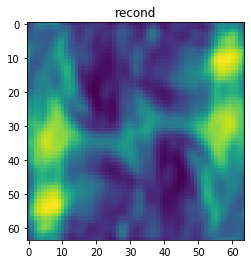

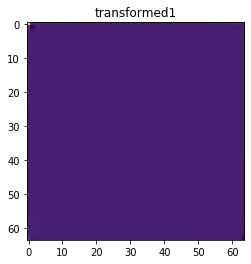

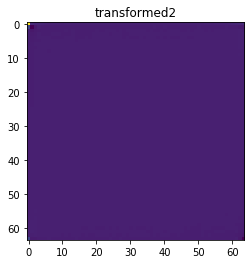

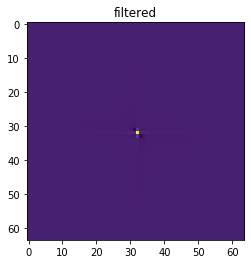

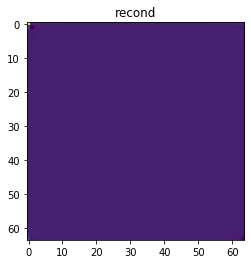

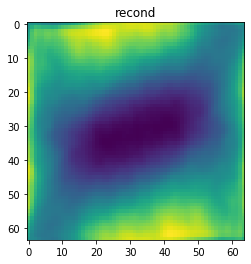

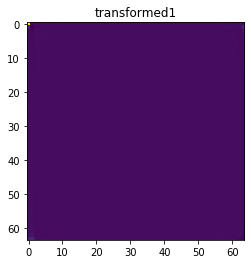

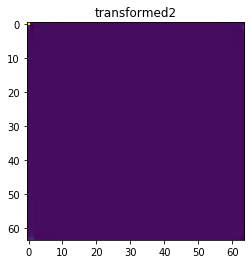

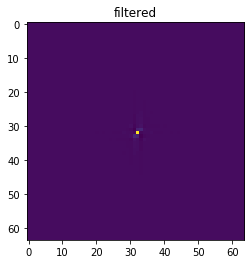

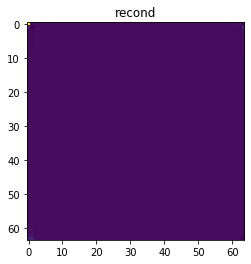

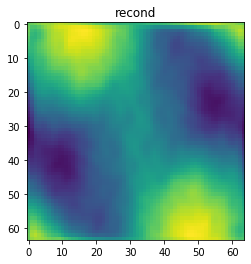

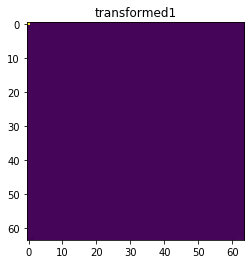

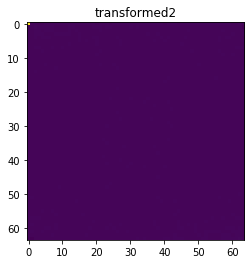

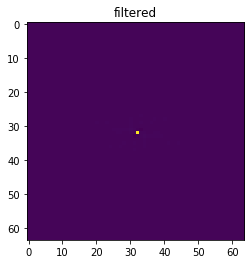

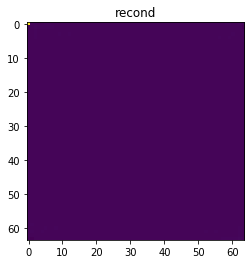

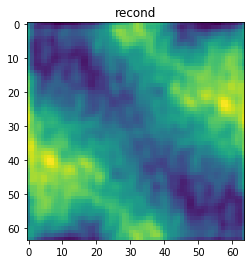

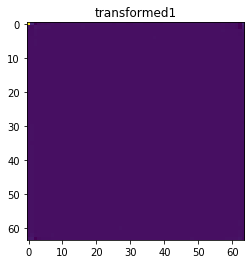

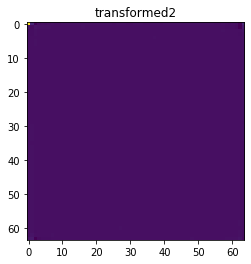

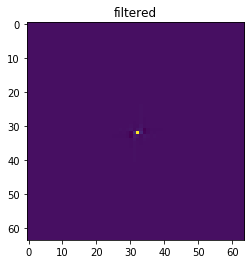

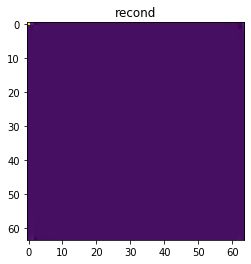

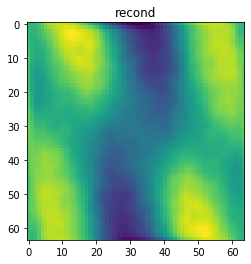

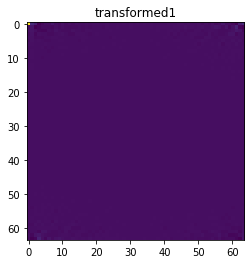

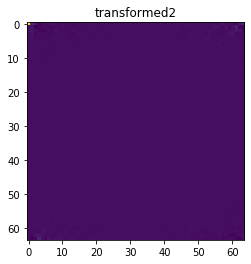

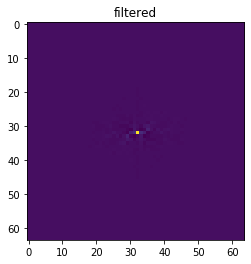

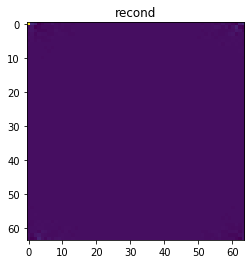

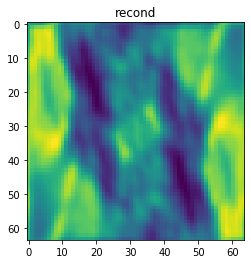

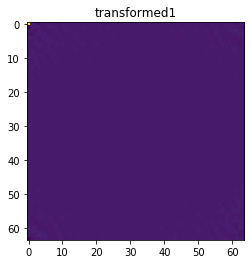

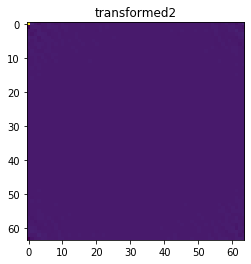

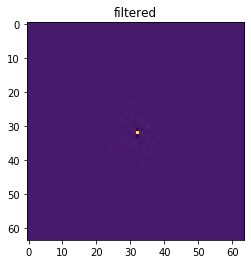

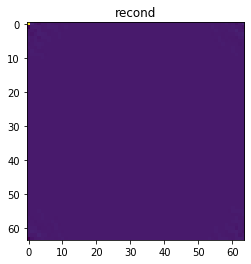

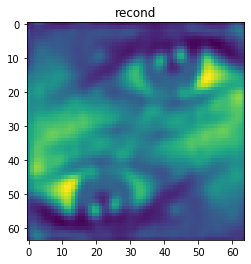

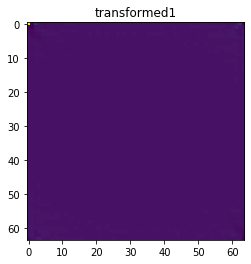

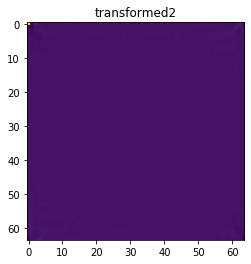

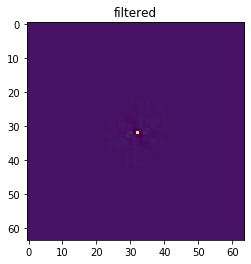

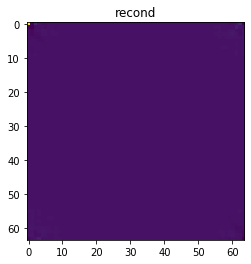

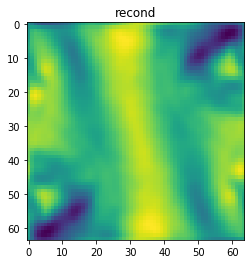

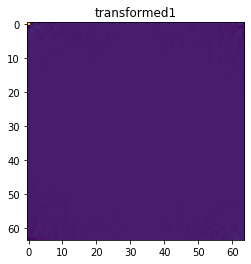

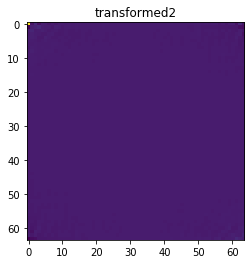

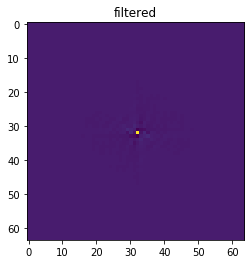

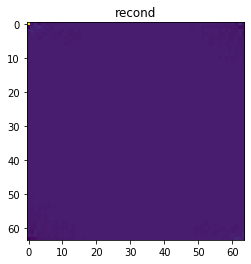

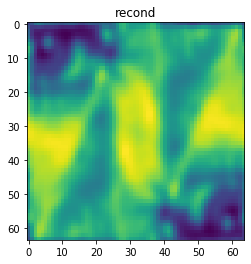

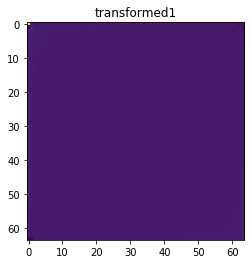

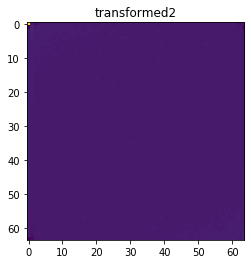

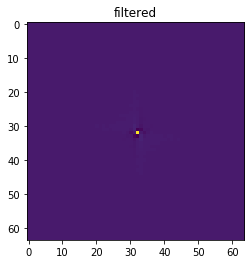

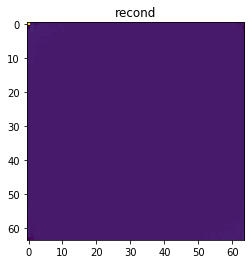

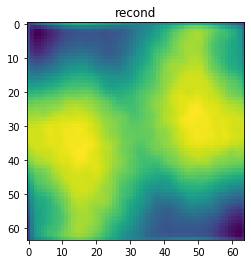

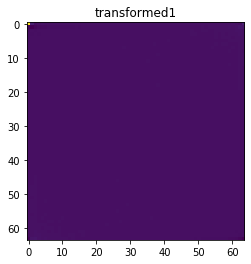

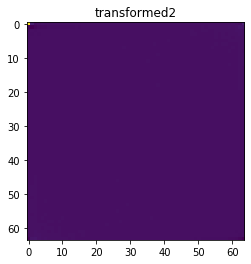

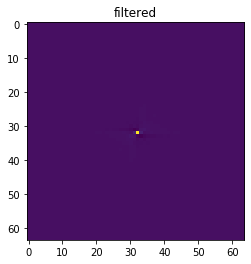

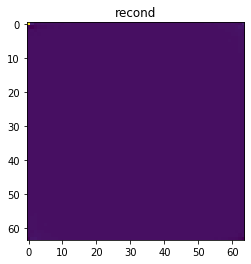

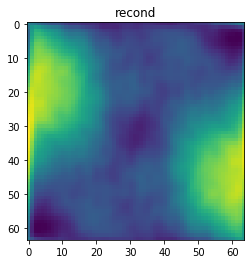

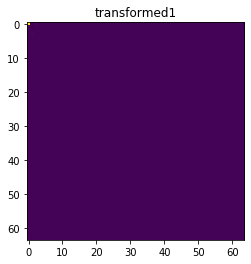

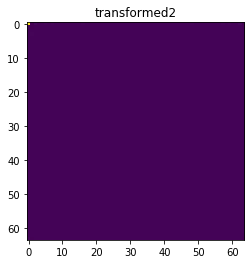

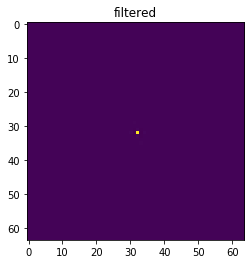

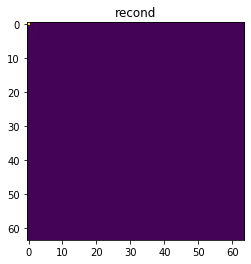

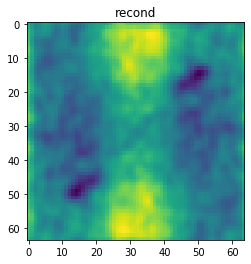

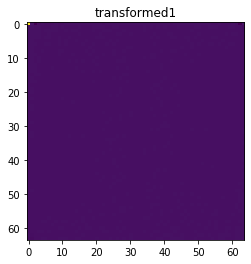

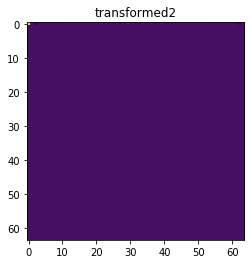

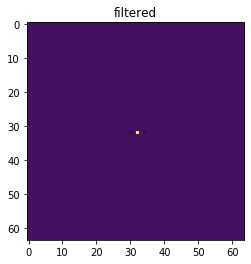

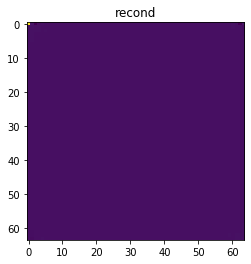

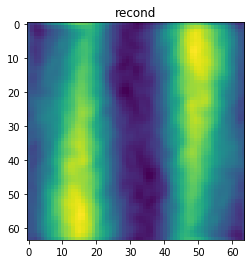

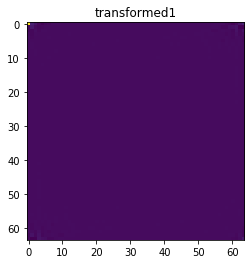

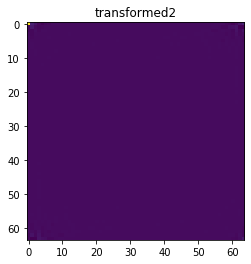

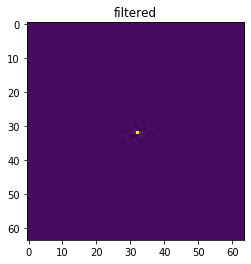

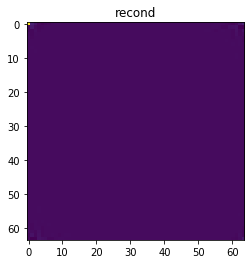

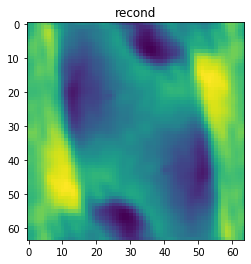

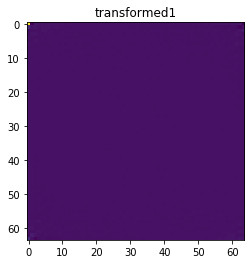

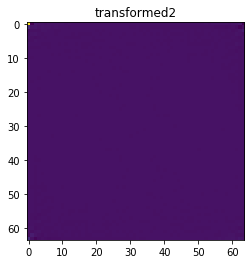

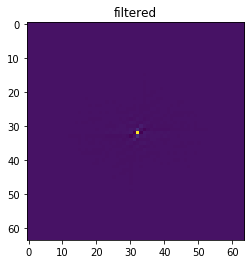

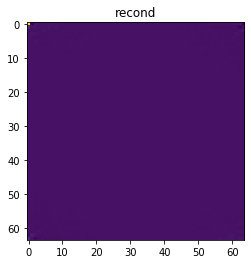

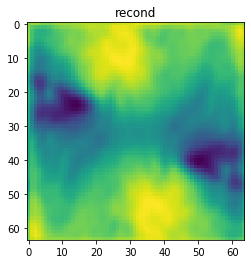

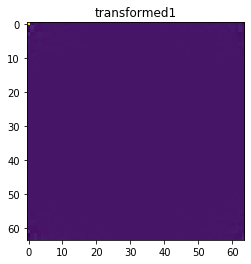

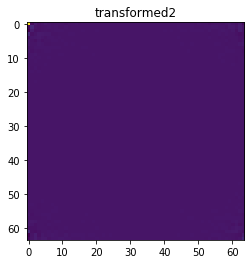

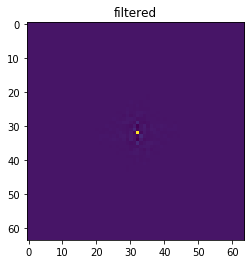

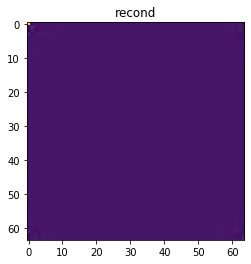

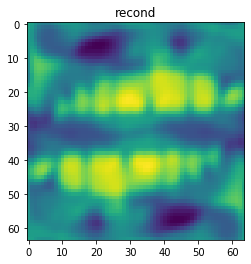

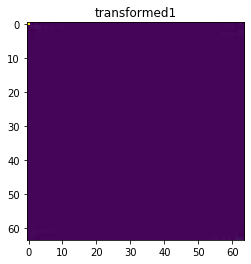

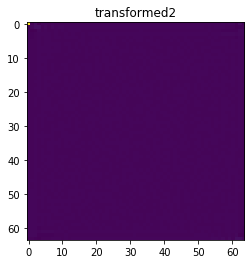

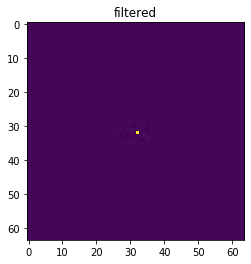

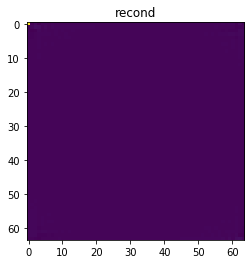

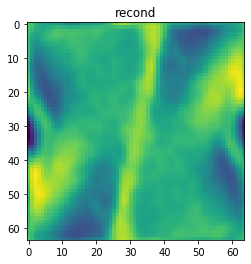

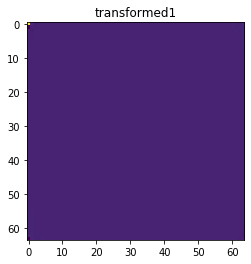

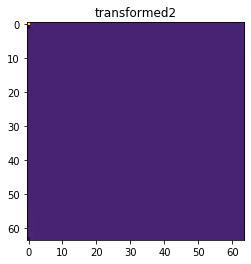

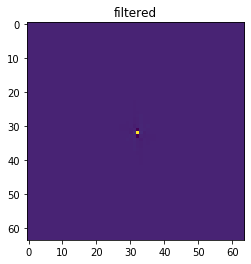

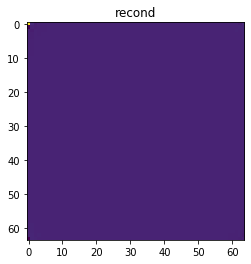

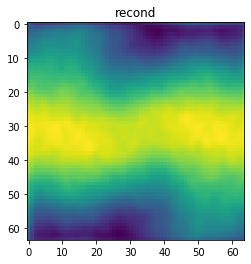

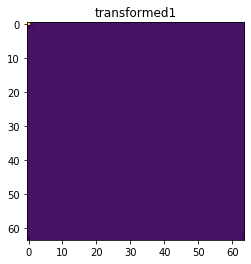

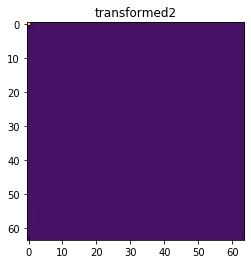

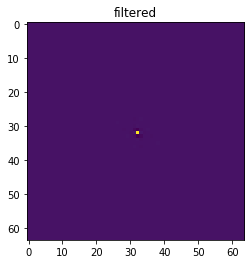

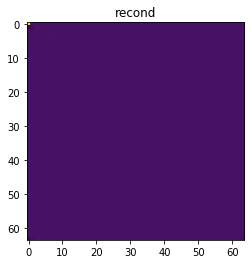

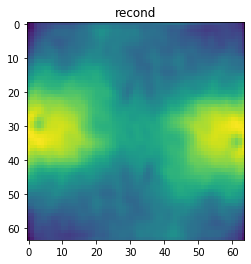

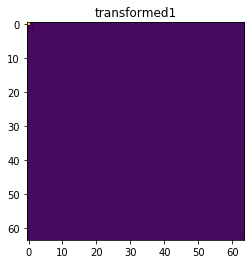

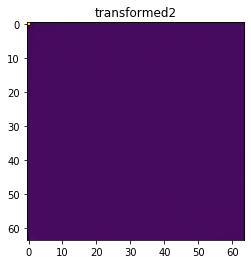

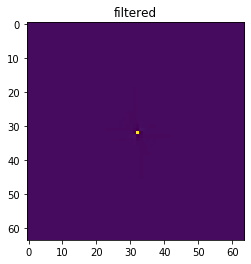

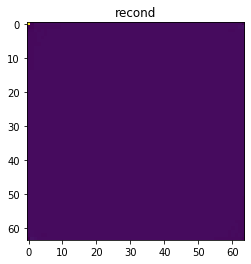

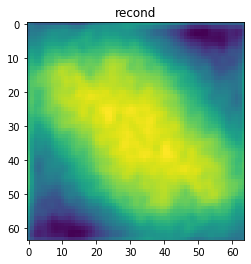

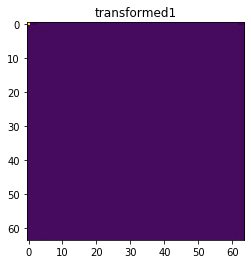

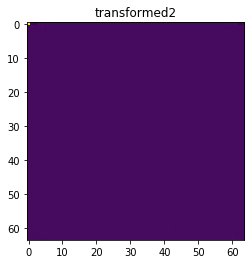

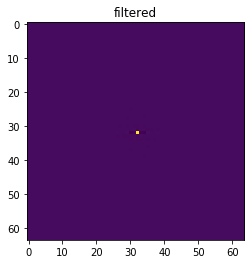

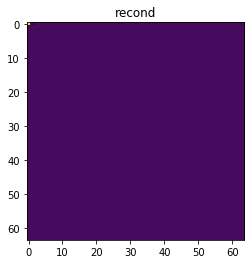

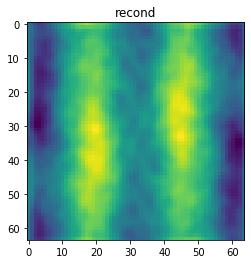

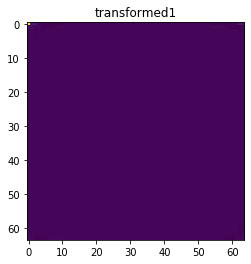

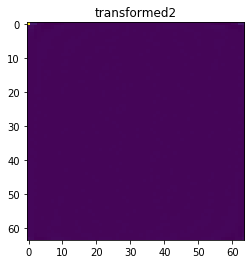

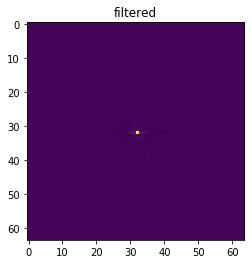

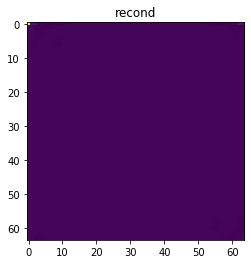

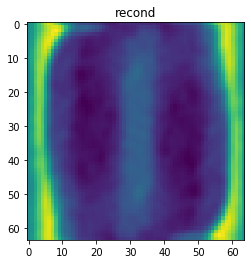

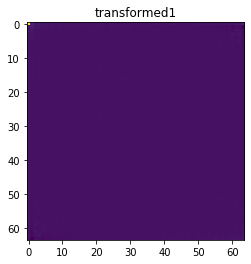

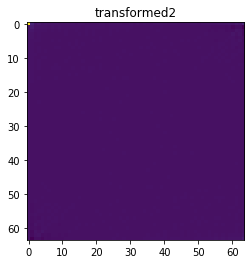

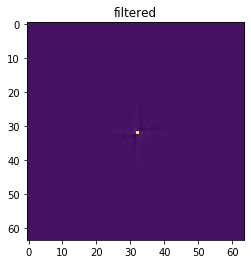

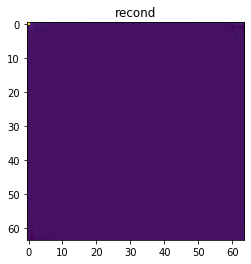

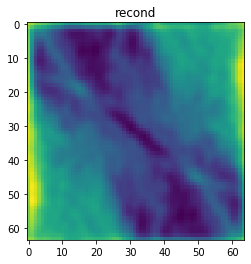

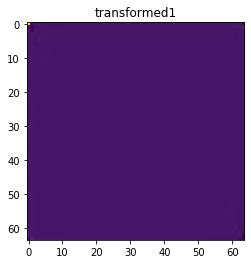

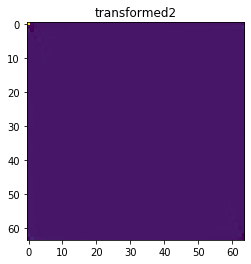

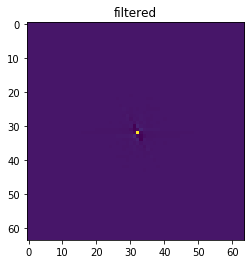

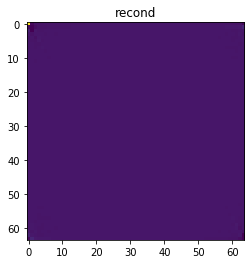

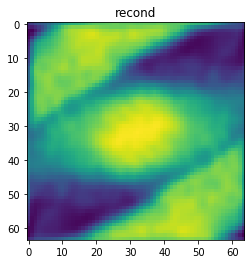

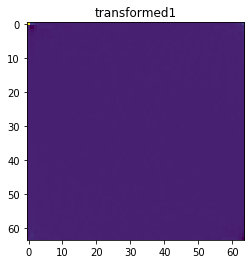

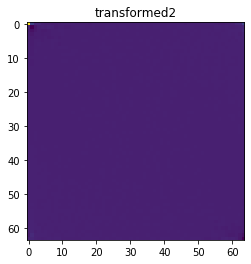

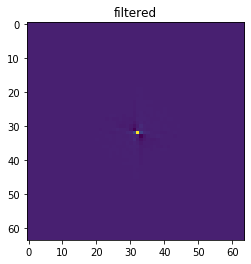

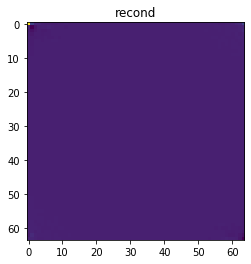

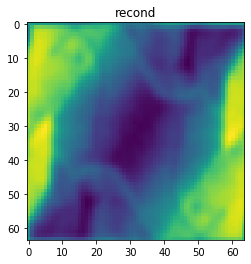

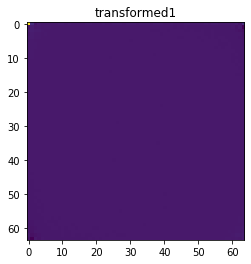

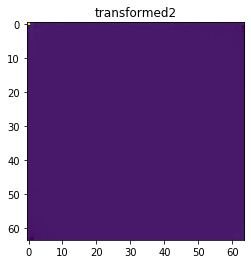

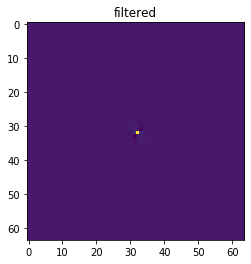

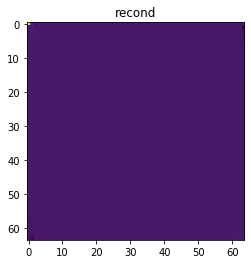

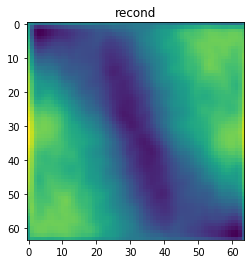

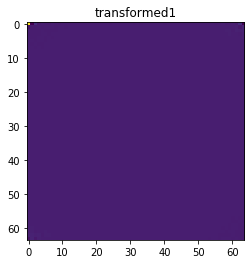

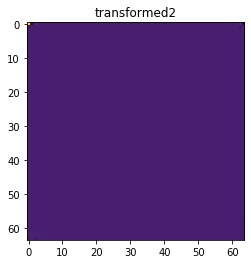

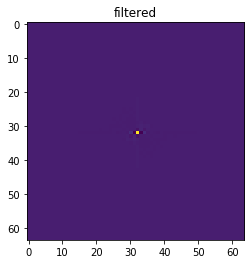

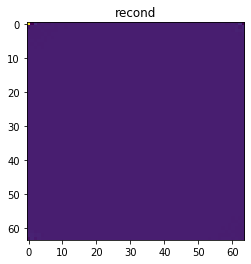

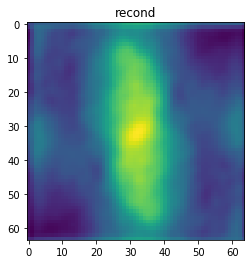

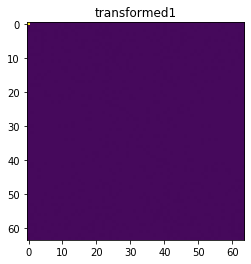

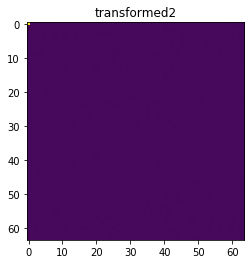

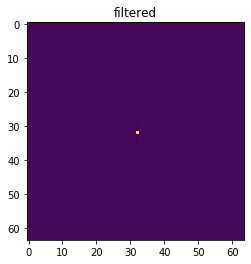

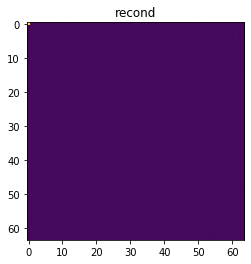

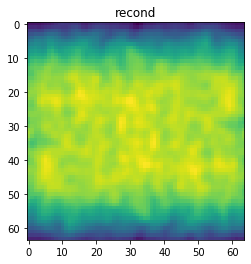

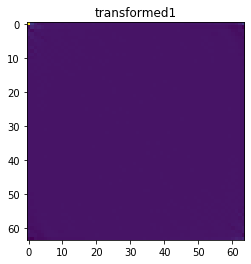

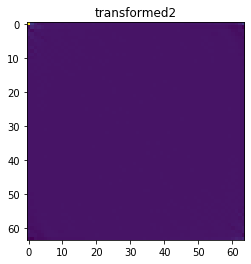

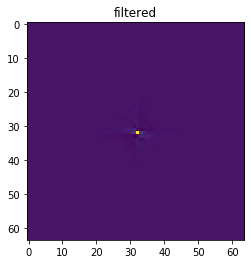

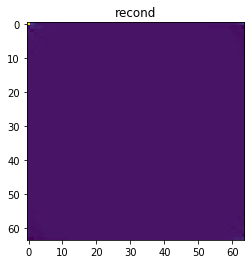

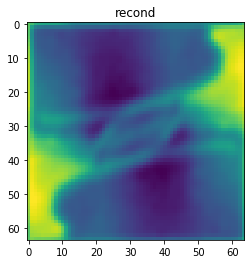

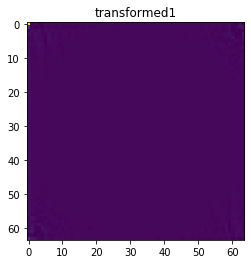

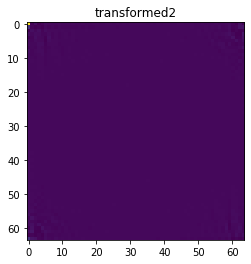

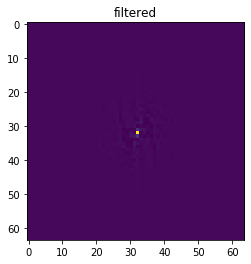

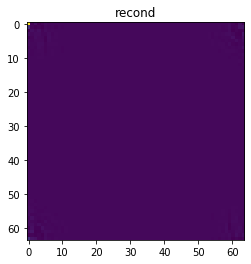

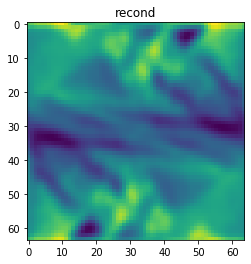

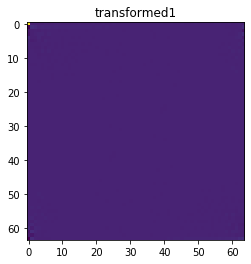

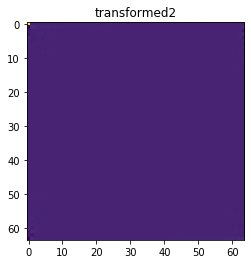

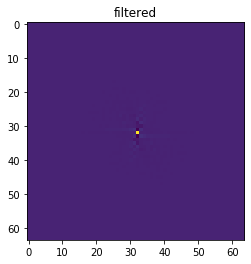

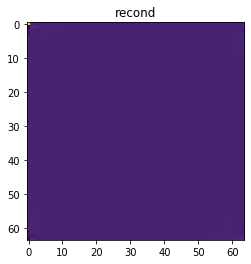

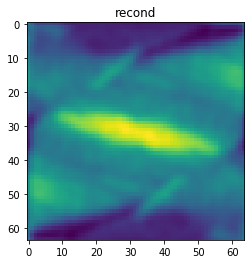

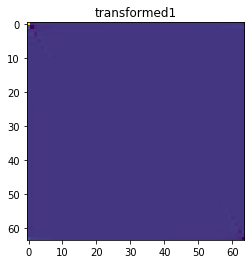

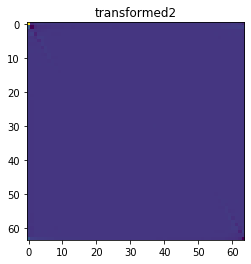

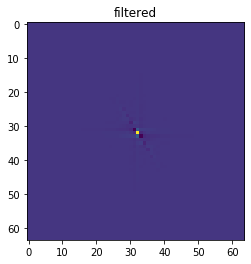

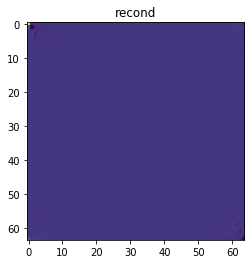

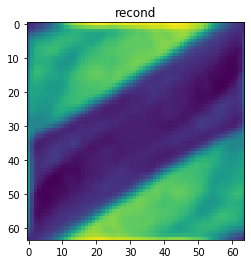

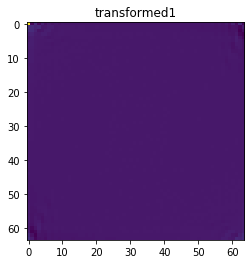

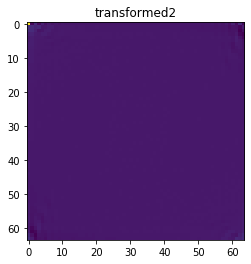

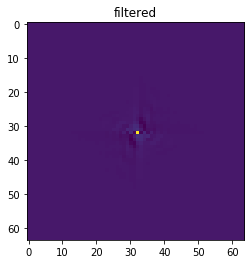

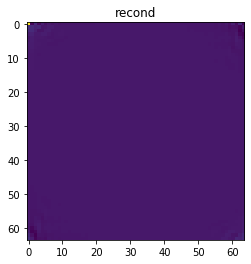

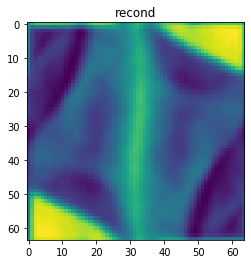

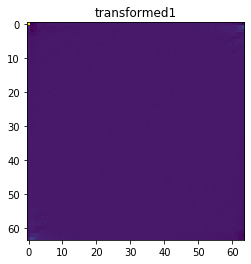

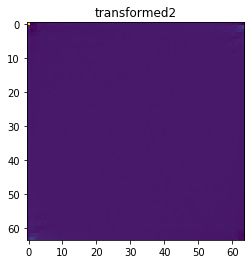

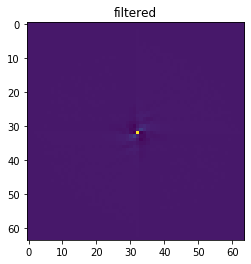

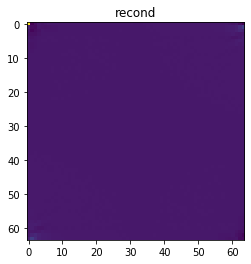

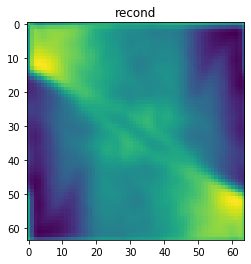

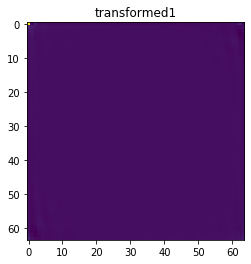

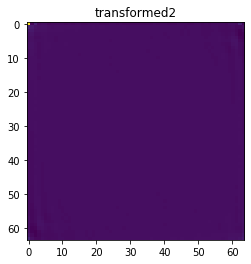

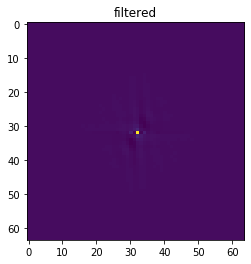

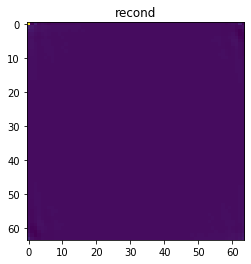

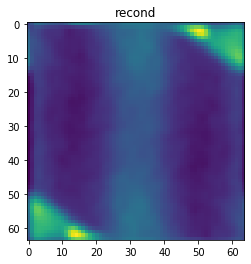

In [106]:
gauss = gaussian_kernel(10, norm=False)
print(gauss.shape)

# becuase the filter kernel is odd-sized the padding is 1 more on the left/above than right/below
pad_width = (block_size-gauss.shape[0])//2
lp_filter = np.pad(gauss, ((pad_width+1,pad_width),(pad_width+1,pad_width)), mode='constant')
plt.imshow(lp_filter, cmap="gray")
plt.show()
for i in range(0,im.shape[0],block_size):
    for j in range(0,im.shape[1],block_size):
        
        block = im[i:i+block_size,j:j+block_size]
        #plt.imshow(block)
        #plt.title("og")
        #plt.show()
        dft_block = np.fft.fft2(block)
        plt.imshow(dft_block.real)
        plt.title("transformed1")
        plt.show()
        dft_block=np.fft.ifftshift(np.fft.fftshift(dft_block))
        plt.imshow(dft_block.real)
        plt.title("transformed2")
        plt.show()
        dft_block=np.fft.fftshift(dft_block)
        #plt.imshow(dft_block.real)
        #plt.title("transformed")
        #plt.show()
        plt.imshow(np.multiply(dft_block.real, lp_filter))
        plt.title("filtered")
        plt.show()
        plt.imshow(np.fft.ifftshift(np.multiply(dft_block.real, lp_filter)).real)
        plt.title("recond")
        plt.show()
        plt.imshow(np.fft.ifft2(np.fft.ifftshift(np.multiply(dft_block.real, lp_filter))).real)
        plt.title("recond")
        plt.show()
        dft[i:i+block_size,j:j+block_size] = dft_block
#ft = np.fft.fft2(im)
#lt.imshow(np.fft.ifft2(dft).real)
#lt.show()

(61, 61)
(64, 64)


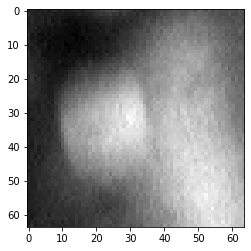

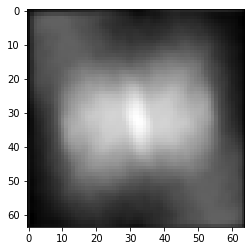

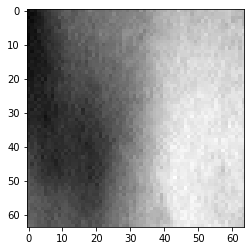

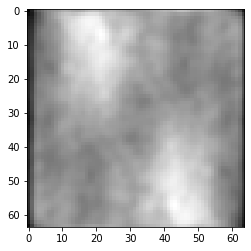

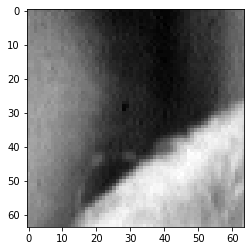

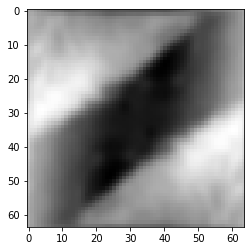

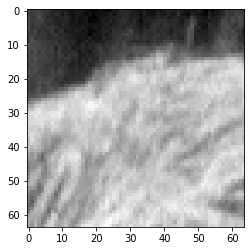

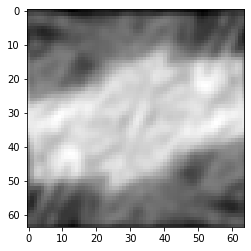

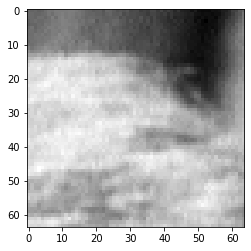

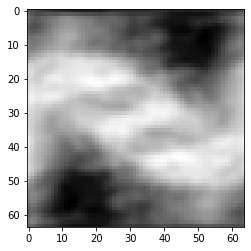

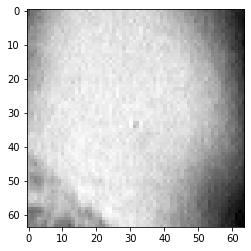

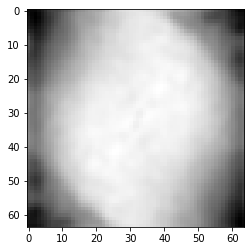

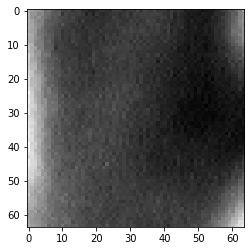

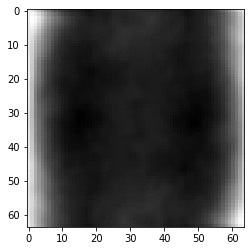

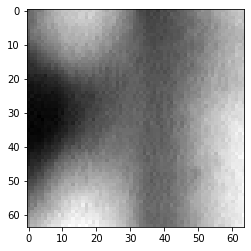

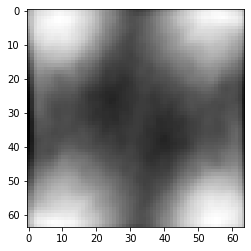

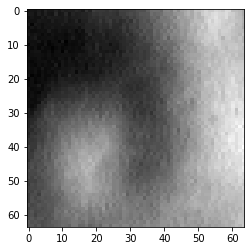

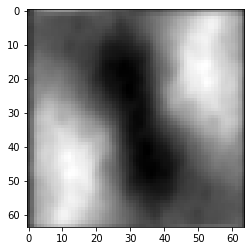

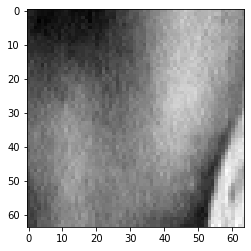

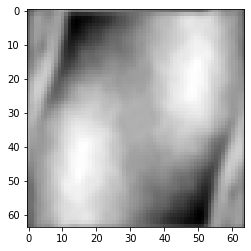

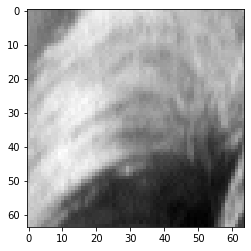

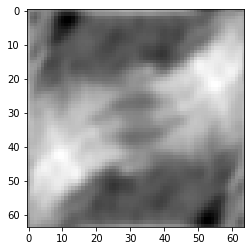

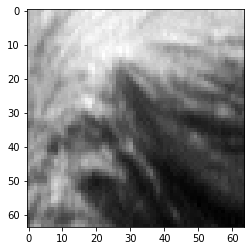

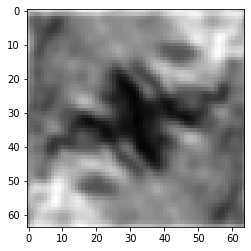

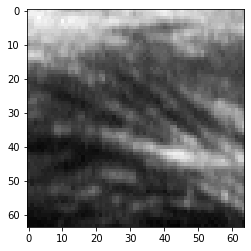

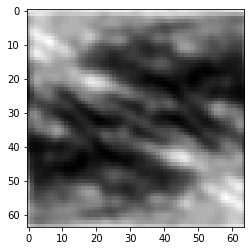

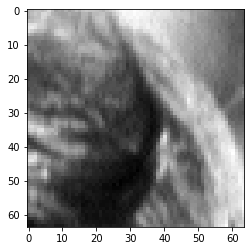

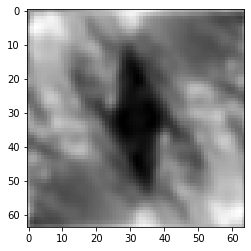

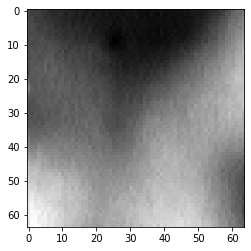

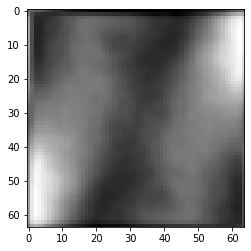

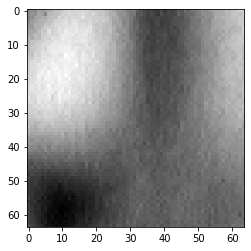

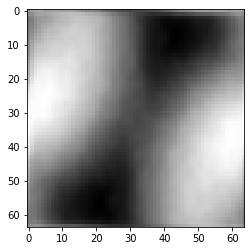

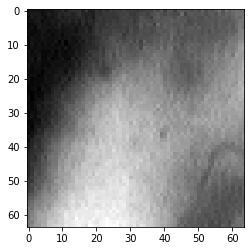

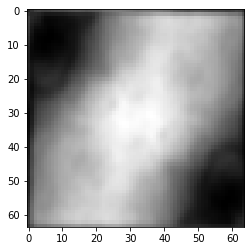

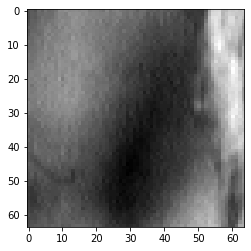

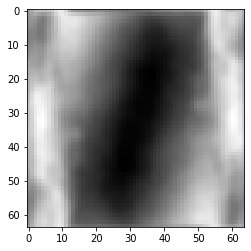

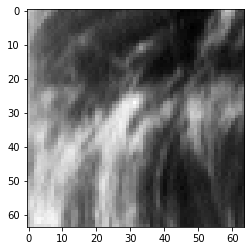

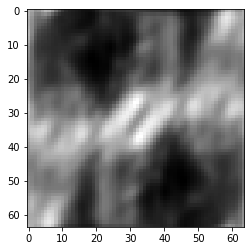

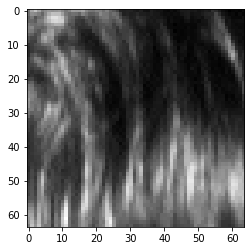

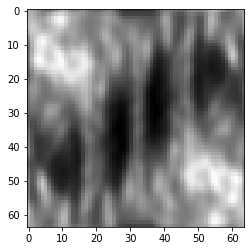

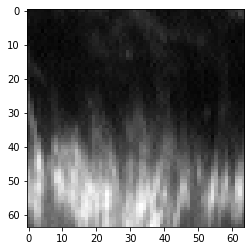

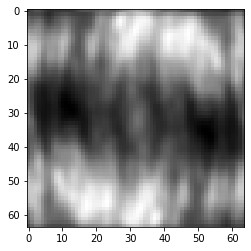

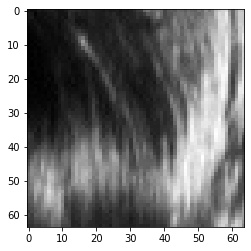

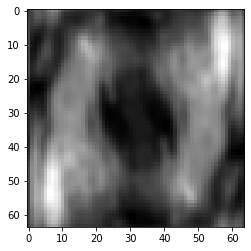

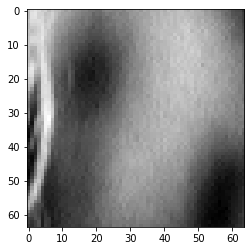

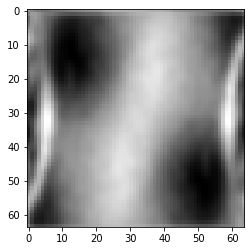

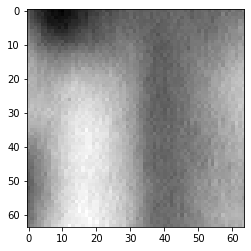

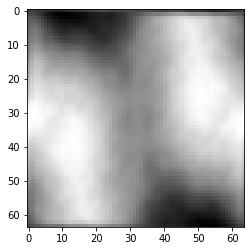

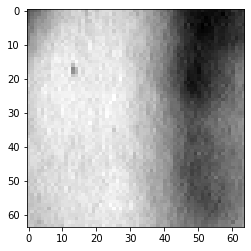

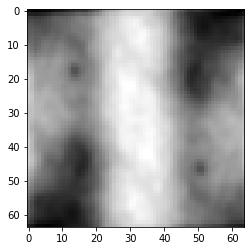

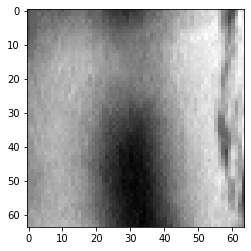

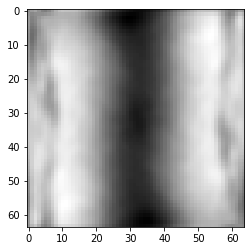

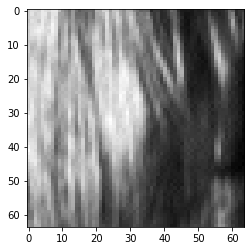

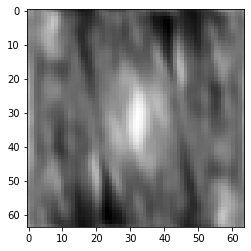

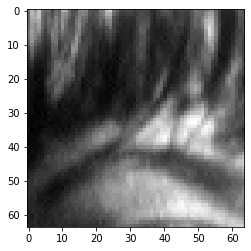

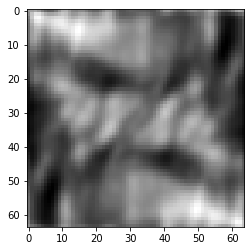

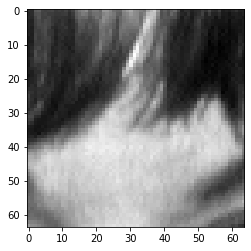

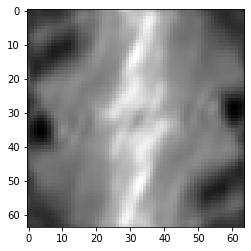

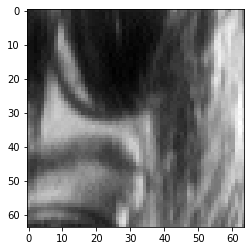

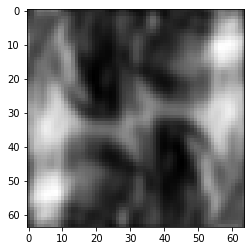

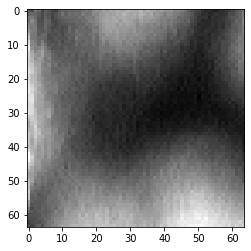

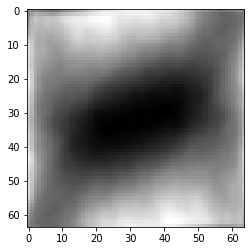

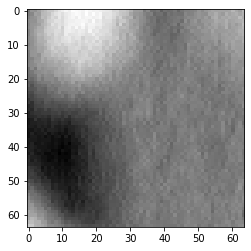

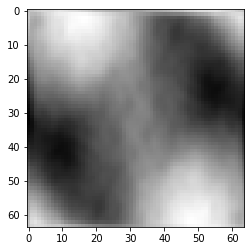

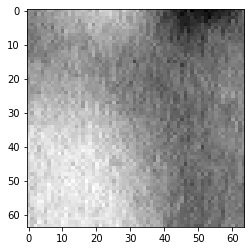

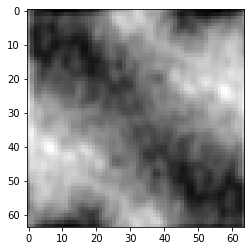

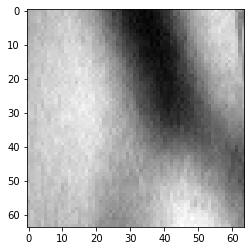

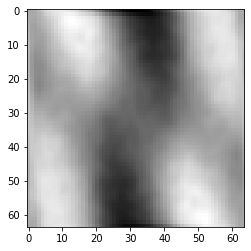

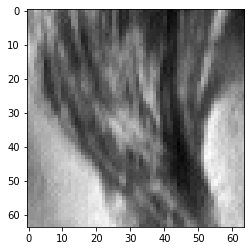

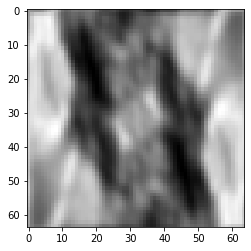

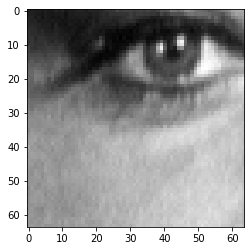

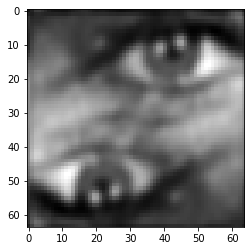

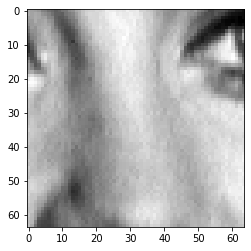

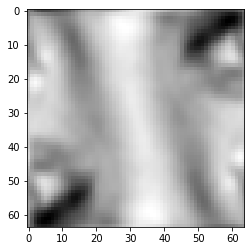

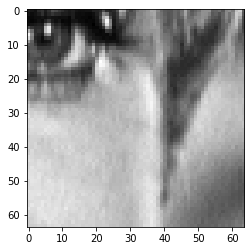

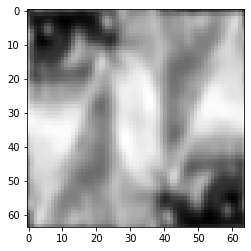

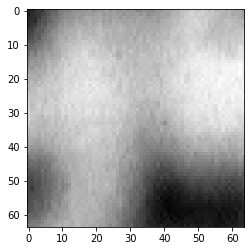

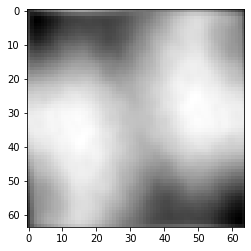

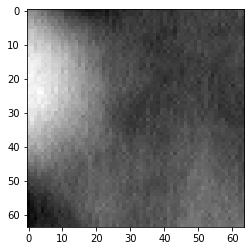

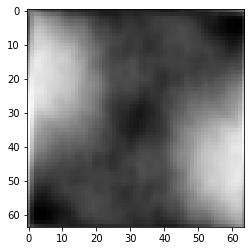

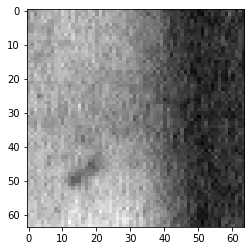

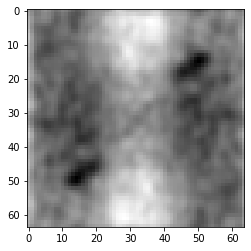

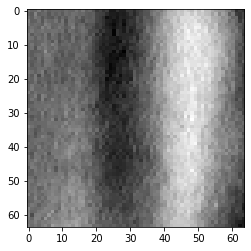

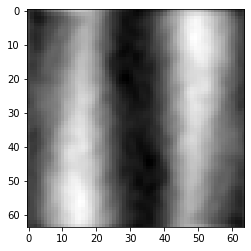

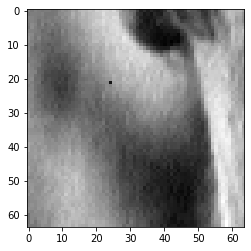

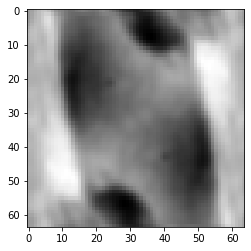

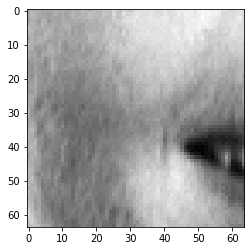

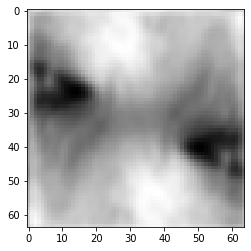

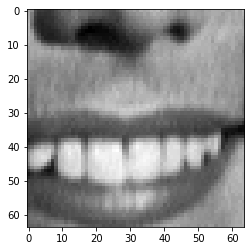

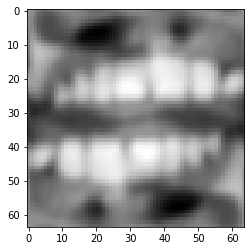

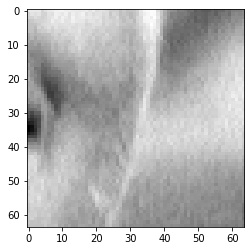

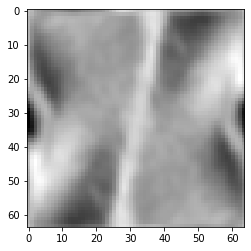

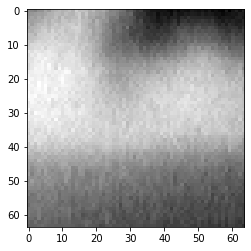

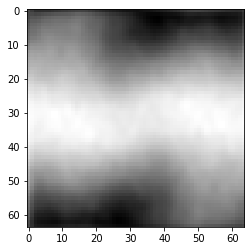

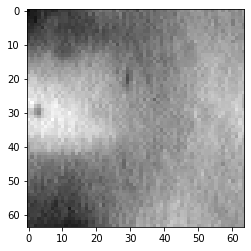

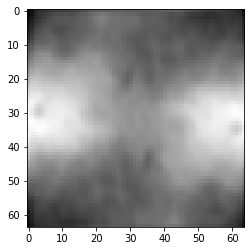

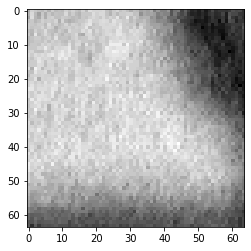

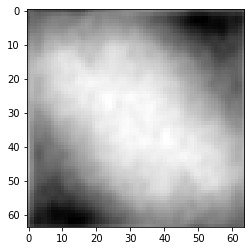

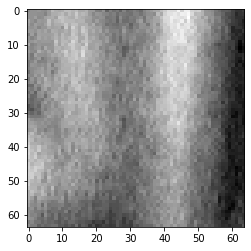

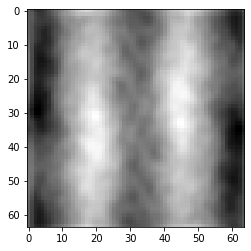

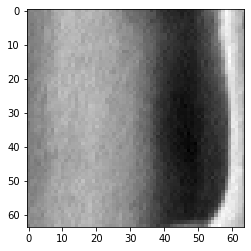

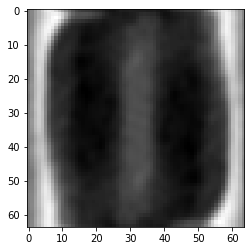

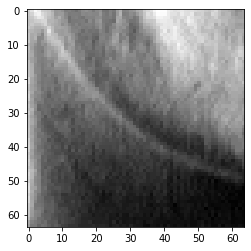

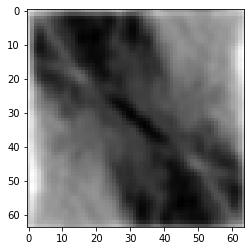

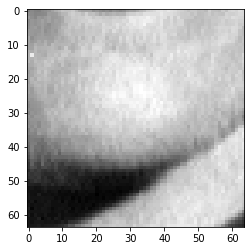

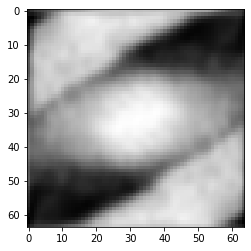

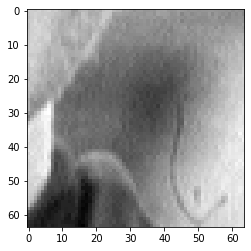

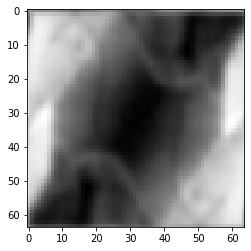

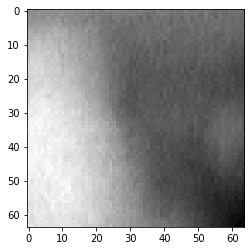

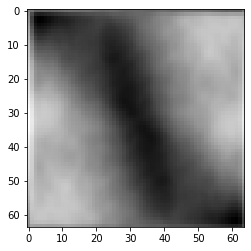

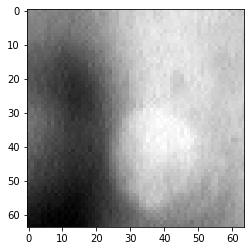

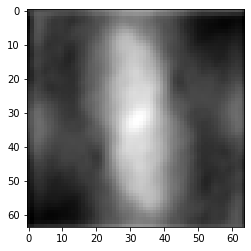

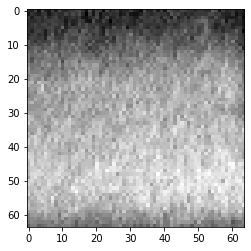

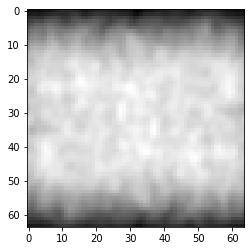

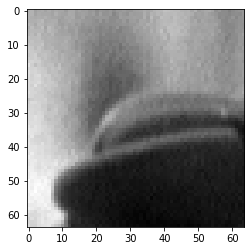

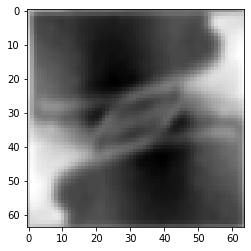

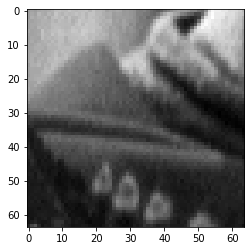

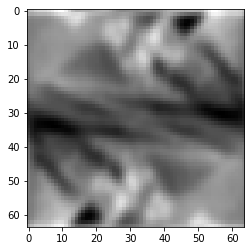

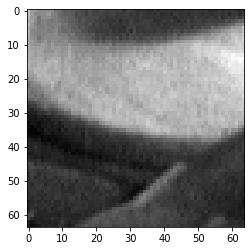

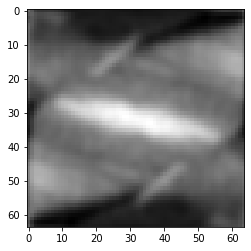

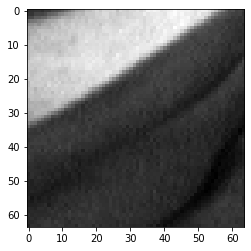

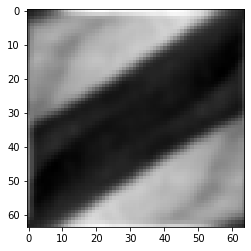

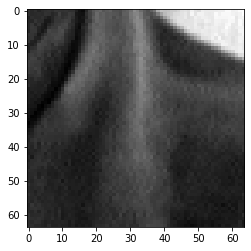

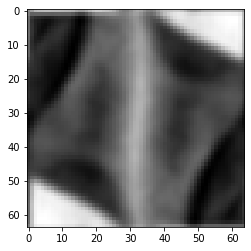

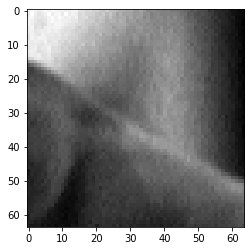

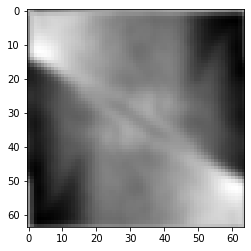

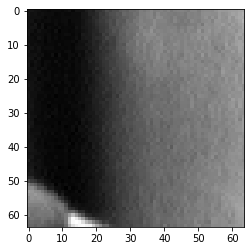

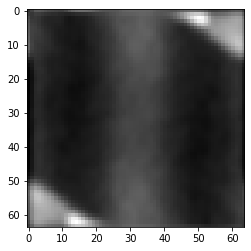

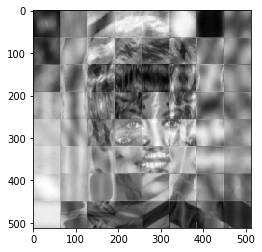

In [99]:
def dft_block_filter(block, kernel):
    dft_filtered = np.fft.ifftshift(np.multiply(block.real, kernel)) # element wise multiplication
    return dft_filtered
    
def dft_block_threshold(block, threshold):
    threshd = np.zeros(block.shape)
    big = -10000
    for x in range(len(block.ravel())):
        if block.ravel()[x]>big:
            big = block.ravel()[x]
    for y in range(len(block.ravel())):
        if block.ravel()[y]>threshold*big:
            threshd.ravel()[y] = block.ravel()[y]
        else:
            threshd.ravel()[y] = 0
    return threshd
    
def inv_dft_block(block):
    im_filtered = np.fft.ifft2(block)
    return im_filtered.real

gauss = gaussian_kernel(10, norm=False)
print(gauss.shape)

# becuase the filter kernel is odd-sized the padding is 1 more on the left/above than right/below
pad_width = (block_size-gauss.shape[0])//2
lp_filter = np.pad(gauss, ((pad_width+1,pad_width),(pad_width+1,pad_width)), mode='constant')
print(lp_filter.shape)

recon = np.zeros(dft.shape)

for i in range(0,im.shape[0],block_size):
    for j in range(0,im.shape[1],block_size):
        dft_block_filt = dft_block_filter(dft[i:i+block_size,j:j+block_size],lp_filter)
        plt.imshow(im[i:i+block_size,j:j+block_size],cmap="gray")
        plt.show()
        #dft_block_filt = dft_block_threshold(dft[i:i+block_size,j:j+block_size],0.9)
        inv_block = inv_dft_block(dft_block_filt)
        recon[i:i+block_size,j:j+block_size] = inv_block
        plt.imshow(recon[i:i+block_size,j:j+block_size],cmap="gray")
        plt.show()
plt.imshow(recon,cmap="gray")
plt.show()

## Exercise 5

1. Use a block based DFT and filter and reconstruct the blocks.

2. What happens to the reconstructed image if you thresold the blocks by a percentage of the 
magnitude instead of fitlering them? 

3. Try adding noise to the image before doing your block-based DFT filtering. Calculate the Signal-to-noise ratio
of the image before and after filtering.

4. Can you think of a way to filter each block so as to preserve local edges and texture information?